# Neural Machine Translation by Jointly Learning to Align and Translate

_This notebook demonstrates the implementation of Seq2Seq architecture with attention mechanism proposed by [Bahdanau et al., 2014](https://arxiv.org/pdf/1409.0473.pdf) for neural machine translation (NMT)._

> _Sequence-to-sequence models are deep learning models that have achieved a lot of success in tasks like machine translation, text summarization, and image captioning. Google Translate started [using](https://blog.google/products/translate/found-translation-more-accurate-fluent-sentences-google-translate/) such a model in production in late 2016. These models are explained in the two pioneering papers ([Sutskever et al., 2014](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf), [Cho et al., 2014](http://emnlp2014.org/papers/pdf/EMNLP2014179.pdf)). (Excerpt from a [blog post](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) by Jay Alammar)_

Sequence-to-sequence (aka seq2seq) model is an end-to-end deep learning model which transforms one sequence to another. It consists of two recurrent neural networks:
- encoder, which encodes an input sequence of variable size into a context vector of fixed size
- decoder, which unfolds the context vector into a new sequence (output).

![seq2seq model](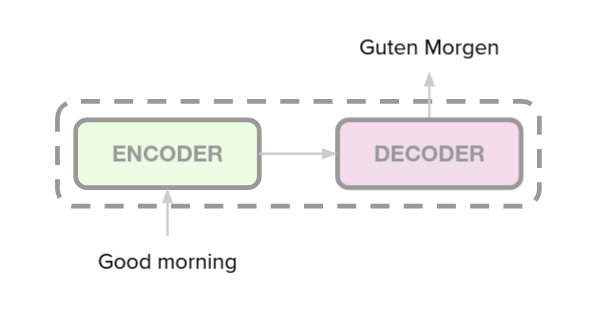 "Seq2Seq Model")
Seq2Seq NMT model can be thought of autoregressive language model where the decoder finds the target sequence that is the most probable conditioned on the input sequence. Mathematically, it can be formulated as follows:

$$
P(y|x) = P(y_1|x) P(y_2|y_1,x) \dots P(y_T|y_1, \dots, y_{T-1}, x)
$$

where:
- \( x \) is the source (input) sequence  
- \( y_t \) is the target token at time step \( t \)  
- \( T \) is the length of the target sequence  

This autoregressive formulation enables the model to learn long-range dependencies
in the target language while remaining conditioned on the source sequence.

We will build a seq2seq model with attention for English to German translation using PyTorch.

# Importing Packages

In [1]:
%%capture
!pip install sacrebleu --quiet
import math
import random
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
from torch.utils.data import Sampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from datasets import load_dataset
import warnings
from tqdm.notebook import tqdm
import sacrebleu

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
data = load_dataset('bentrevett/multi30k')
data

README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [3]:
data['train'][9]

#plt Configs
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize']=12,8

In [4]:
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
train_data = data['train']
test_data = data['test']
valid_data = data['validation']

# Sentencepiece Tokenizer Training

In [7]:
!pip install -q sentencepiece
import sentencepiece as spm 
import os
warnings.filterwarnings('ignore')
with open('/kaggle/working/train.en','w',encoding='utf-8') as f_en, \
     open('/kaggle/working/train.de','w',encoding='utf-8') as f_de:
     for ex in train_data:
         f_en.write(ex['en'].lower()+'\n')
         f_de.write(ex['de'].lower()+'\n')
spm.SentencePieceTrainer.train(
    input='/kaggle/working/train.en,/kaggle/working/train.de',
    model_prefix='/kaggle/working/spm_en_de',
    vocab_size=12000,
    model_type='unigram',
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3
)
sp = spm.SentencePieceProcessor(
    model_file='/kaggle/working/spm_en_de.model'
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /kaggle/working/train.en
  input: /kaggle/working/train.de
  input_format: 
  model_prefix: /kaggle/working/spm_en_de
  model_type: UNIGRAM
  vocab_size: 12000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <p

In [8]:
#sp = spm.SentencePieceprocessor()
sp.load('/kaggle/working/spm_en_de.model')

def tokenize_en(text):
    """
    Translated english text sequence into a list of tokens
    """
    return sp.encode(text.lower(),out_type=int)

def tokenize_de(text):
    """ Translated German text sequence into a list of tokens.
    """
    return sp.encode(text.lower(), out_type=int)
PAD_TOKEN='<pad>'
SOS_TOKEN='<s>'
EOS_TOKEN='</s>'
UNK_TOKEN='<unk>'
PAD_IDX= sp.pad_id()
SOS_IDX = sp.bos_id()
EOS_IDX = sp.eos_id()
UNK_IDX = sp.unk_id()

VOCAB_SIZE = sp.get_piece_size()

print(f'English vocabulary: {VOCAB_SIZE} words')
print(f'French vocabulary: {VOCAB_SIZE} words')
print('Since The Size of En and De is same')

print(f'# of Training examples:{len(train_data)}')
print(f'# of testing examples: {len(test_data)}')
print(f'# of validation examples: {len(valid_data)}')

print(train_data[0].keys())
print(train_data[0])
print(train_data[0].values())

English vocabulary: 12000 words
French vocabulary: 12000 words
Since The Size of En and De is same
# of Training examples:29000
# of testing examples: 1000
# of validation examples: 1014
dict_keys(['en', 'de'])
{'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}
dict_values(['Two young, White males are outside near many bushes.', 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'])


## Encoding and Batch Mapping

In [9]:
from datasets import disable_caching
disable_caching()

def encode(batch):
    src = [[SOS_IDX] + tokenize_en(ex) + [EOS_IDX] for ex in batch['en']]
    trg = [[SOS_IDX] + tokenize_de(ex) + [EOS_IDX] for ex in batch['de']]
    return {
        'src':src,
        'trg':trg,
        'src_len':[len(s) for s in src],
        'trg_len':[len(t) for t in trg]
    }
train_encoded = train_data.map(
    encode,
    batched=True,
    batch_size=1000,
    remove_columns=train_data.column_names,
    desc="Encoding Train data"
)
test_encoded = test_data.map(
    encode,
    batched=True,
    batch_size=1000,
    desc="Encoding Test data",
    remove_columns=test_data.column_names
)
valid_encoded = valid_data.map(
    encode,
    batched=True,
    batch_size=1000,
    desc="Encoding Valid data",
    remove_columns=valid_data.column_names
)

Encoding Train data:   0%|          | 0/29000 [00:00<?, ? examples/s]

Encoding Test data:   0%|          | 0/1000 [00:00<?, ? examples/s]

Encoding Valid data:   0%|          | 0/1014 [00:00<?, ? examples/s]

# Manual Bucket Batch Sampler

In [10]:
class BucketBatchSampler(Sampler):
    def __init__(self,data,batch_size,shuffle=True):
        self.batch_size=batch_size
        self.shuffle=shuffle
        self.indices = list(range(len(data)))
        self.lengths = [sample['src_len'] for sample in data]
    def __iter__(self):
        self.indices.sort(key=lambda i: self.lengths[i])
        batches=[
            self.indices[i:i+self.batch_size]
            for i in range(0,len(self.indices),self.batch_size)
        ]
        if self.shuffle:
            random.shuffle(batches)
        for batch in batches:
            yield batch
    def __len__(self):
        return len(self.indices)//self.batch_size

# Collate fn

In [11]:
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    src_tensors=[]
    trg_tensors=[]
    for sample in batch:
        src = sample['src']
        trg = sample['trg']

        if len(trg)<2:
            continue
        src_tensors.append(torch.tensor(src,dtype=torch.long))
        trg_tensors.append(torch.tensor(trg,dtype=torch.long))
    if len(src_tensors) == 0:
        return None
    src_lens = torch.tensor([len(s) for s in src_tensors])
    trg_lens = torch.tensor([len(t) for t in trg_tensors])

    src = pad_sequence(src_tensors,batch_first=True,padding_value=PAD_IDX)
    trg = pad_sequence(trg_tensors, batch_first=True, padding_value=PAD_IDX)

    return(
        src.to(device),
        src_lens.to(device),
        trg.to(device),
        trg_lens.to(device)
    )

# Data Loader Packup

In [12]:
from torch.utils.data import DataLoader
BATCH_SIZE=64

train_iterator = list(DataLoader(
    train_encoded,
    batch_sampler = BucketBatchSampler(train_encoded,BATCH_SIZE,shuffle=True),
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory = False
))
valid_iterator = list(DataLoader(
    valid_encoded,
    batch_sampler=BucketBatchSampler(valid_encoded, BATCH_SIZE, shuffle=False),
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=False
))

test_iterator = list(DataLoader(
    test_encoded,
    batch_sampler=BucketBatchSampler(test_encoded, BATCH_SIZE, shuffle=False),
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=False
))

In [13]:
#sanity check
x=next(iter(train_iterator))

print(f'Source: {x[0].shape} source_lengths: {x[1].shape}')
print(f'Target: {x[2].shape} Target_lengths: {x[3].shape}')
print(f'Source: {x[0][:1]} source_lengths: {x[1][:3]}')
print(f'Target: {x[2][:1]} Target_lengths: {x[3][:3]}')

Source: torch.Size([64, 21]) source_lengths: torch.Size([64])
Target: torch.Size([64, 26]) Target_lengths: torch.Size([64])
Source: tensor([[   2,    5,  317,  164,    5,   58, 3142,  571,   19, 3641,  761,  390,
           24,  150,    5,  659,    6,   11,  428,    4,    3]],
       device='cuda:0') source_lengths: tensor([21, 21, 21], device='cuda:0')
Target: tensor([[   2,    7,   18,  490,   44,  211,    8,   10,  832,   92,    8,  729,
           14,   93,   10,  105, 7491,    6,   29,  199,    4,    3,    0,    0,
            0,    0]], device='cuda:0') Target_lengths: tensor([22, 24, 20], device='cuda:0')


# Model Architecture
![seq2seq model with attention](https://jasmijn.bastings.me/annotated_encoder_decoder/images/bahdanau.png)

(Reference: https://bastings.github.io/annotated_encoder_decoder)


### Encoder Module

Encoder reads the input sequence and generate a fixed size context vector. However, because it's very hard for the encoder to encode the entire input sequence into a single vector, the encoder also produces the sequence of hidden states for each token of input sequence. Encoder can be either stacked LSTMs or stacked GRUs where each layer's output are passed as input sequence to the next layer. The final layer's hidden states act as a context vector.

For the implementation in this notebook, we will be using a bidirectional GRU (forward + backward) as a encoder. A forward GRU reads the input sequence from left to right whereas a backward GRU reads the input sequence from right to left. The advantage of using a bidirectional GRU over unidirectional GRU is that we will be able to preserve information from both past and future. Mathematically, it can expressed as follows:

$$
\begin{align}
h_t^\rightarrow &= \text{GRU}^\rightarrow(e(x_t^\rightarrow),\ h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{GRU}^\leftarrow(e(x_t^\leftarrow),\ h_{t-1}^\leftarrow)
\end{align}
$$

where 
- $x_t$ denotes the input token (word) at time step $t$
- $e(x_t^\rightarrow)$ denotes the embedded input token at time step $t$
- $h_t^\rightarrow$ and $h_t^\leftarrow$ denotes the forward and backward hidden state at time step $t$ respectively

We will concatenate the final forward and backward hidden state to preserve the information context from both past and future and apply linear layer followed by relu non-linearity to obtain the context vector $z$ as follows:

$$
z = f([h_t^\rightarrow,\ h_t^\leftarrow])
$$

where
- $[h_t^\rightarrow,\ h_t^\leftarrow]$ denotes concatenation of the final forward and backward hidden state
- $f$ denotes linear layer followed by relu non-linearity

Encoder GRU returns the following:
- `outputs`: stacked forward and backward hidden states from the last layer
- `hidden`: context vector $z$ which acts as initial hidden state for the decoder.


In [14]:
class Encoder(nn.Module):
    """
    Encoder Encodes The Input Sequence into a dense Embedded Context
    """
    def __init__(self,input_size,embed_size,hidden_size,n_layers=1,dropout_rate=0.5):
        super().__init__()
        self.input_size = input_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        
        self.embedding=nn.Embedding(input_size,embed_size)
        self.rnn=nn.GRU(embed_size,hidden_size,n_layers,bidirectional=True, dropout=dropout_rate)
        self.fc=nn.Linear(hidden_size*2,hidden_size)
        self.dropout=nn.Dropout(dropout_rate)

    def load_pretrained(self,embeddings,fine_tune=False):
        self.embeddings.weights=nn.Parameter(embeddings)
        for parameter in self.embeddings.parameters():
            p.required_grad=fine_tune
    def forward(self,x,lengths):
        """
        where x : (seq_len,batch_size)
        lengths : (batch_size)
        """
        embed=self.dropout(self.embedding(x))

        packed_embed=pack_padded_sequence(embed,lengths.to('cpu'),enforce_sorted=False)
        packed_outputs,hidden = self.rnn(packed_embed)
        outputs,_ = pad_packed_sequence(packed_outputs)
        #Outputs consists of hidden representation at each token parse 
        hidden = F.relu(self.fc(torch.cat([h for h in hidden[-2:]],dim=1)))
        #hidden is The Hidden representation of entire sequence in simple its fine graded compressed Ver
        return outputs,hidden

# BahdanauAttention Module

Although RNNs are good for capturing temporal dependencies, but they fail to preserve the complete context for long sequences. It is very likely that the information context for the intial time steps would be lost by the end of the sequence since we are encoding the input sequence into a single context vector. 

Wouldn't it be nice if we are able to focus only on the relevant parts of the input sequence? This is where "Attention Mechanism" comes to provide the luxury of focusing on different parts of encoded sequence thereby allowing the context to be preserved from beginning to end during the decoding stage. This technique was introduced by [Bahdanau et al., 2014](https://arxiv.org/abs/1409.0473) and [Luong et al., 2015](https://arxiv.org/abs/1508.04025).

For the implementation in this notebook, we will be using attention mechanism introduced by [Bahdanau et al., 2014](https://arxiv.org/abs/1409.0473) which is a MLP based additive attention. We calculate the alignment scores using the encoder outputs and decoder hidden states as follows:

$$
e_t = \text{relu}(W_1 H + W_2 s_{t-1}) \\
\alpha_t = \text{softmax}(V \cdot e_t)
$$

where
- e_t is the attention energy at the time step $t$
- $W_1$ and $W_2$ are learned attention parameters for encoder outputs $H$ and previous decoder hidden state $s_{t-1}$ respectively
- $V$ is another learned attention parameter for the attention energy $e_t$
- $\alpha_t$ is the alignment score for time step $t$

We use the above alignment scores to calculate the weighted sum of encoder outputs also known as context vector $c_t$ for time step $t$ as follows:

$$
c_t = \alpha_t H
$$

Attention Module returns the following:
- `context_vector`: weighted sum of encoder outputs wrt alignment score
- `alphas`: alignment scores indicating how well inputs around position $i$ match with outputs around position $j$


In [15]:
class BahdanauAttention(nn.Module):
    """Implements Additive Attention Proposed by Bahdanau et al, 2014"""
    def __init__(self,hidden_size):
        super().__init__()
        self.hidden_size=hidden_size
        
        self.Ws = nn.Linear(hidden_size*2,hidden_size,bias=False)
        self.Wh = nn.Linear(hidden_size,hidden_size,bias=False)
        self.V = nn.Linear(hidden_size,1,bias=False)

    def forward(self,hidden,enc_outputs,enc_masks):
        """
        hidden: (batch_size,hidden_size)
        enc_outputs : (seq_len, batch_size,hidden_size*2)
        enc_masks: (batch_size, seq_len)
        """
        seq_len = enc_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1,seq_len,1)
        enc_outputs = enc_outputs.permute(1,0,2)

        energy = torch.tanh(self.Ws(enc_outputs)+self.Wh(hidden))
        scores = self.V(energy)
        scores = scores.squeeze(2)
        scores = scores.masked_fill(enc_masks==0, float('-inf'))
        alphas = F.softmax(scores,dim=-1)
        #bmm-> batch matrix Multiplication
        """
        Here alphas: (B,T)
        enc_outputs: (B,1,T)
        matrix rule (B, n, m) × (B, m, p) → (B, n, p)
        so, (B, 1, T)×(B, T, 2H)->(B,1,2H)
        """
        context_vector = torch.bmm(alphas.unsqueeze(1), enc_outputs)

        return context_vector,alphas

# Decoder Module With Attention

Decoder is a conditional GRU since we will be using it as a language model to decode the output sequence conditioned on generated sequence so far and input sequence. Here the decoder contains the attention module which allows to preserve the information context and generate output sequence of better quality.

For the implementation in this notebook, we will be using a unidirectional GRU with attention module. The decoder generates next output word with high probability at time step using the current output word, weighted encoder outputs, previous decoder hidden state as follows:

$$
s_t = \text{GRU}(e(y_t), c_t, s_{t-1}) \\
\hat{y}_{t+1} = f([e(y_t),\ c_t,\ s_t])
$$

where
- $y_t$ denotes the current output token (word) at time step $t$
- $e(y_t)$ denotes the current embedded output token at time step $t$
- $c_t$ denotes the context vector (weighted encoder outputs) at time step $t$
- $s_{t-1}$ and $s_t$ denotes the previous and current decoder hidden state
- $f$ denotes a linear layer
- $\hat{y}_{t+1}$ denotes next predicted word in the output sequence


In [16]:
class DecoderWithAttention(nn.Module):
    """
    Decoder decodes the encoded dense Embedding context into a Sequence with use 
    -of Attention Mechanism
    """
    def __init__(self,output_size,embed_size,hidden_size,n_layers=1,dropout_rate=0.5):
        super().__init__()
        self.output_size = output_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate

        self.embedding = nn.Embedding(output_size,embed_size)
        self.rnn = nn.GRU(embed_size+hidden_size*2, hidden_size,n_layers,bidirectional=False,dropout=dropout_rate)
        self.attention = BahdanauAttention(hidden_size)
        self.fc = nn.Linear(embed_size+hidden_size+hidden_size*2,output_size)
        self.dropout = nn.Dropout(dropout_rate)
    def load_pretrained_embeddings(self, embeddings, fine_tune=False):
        self.embedding.weight = nn.Parameter(embeddings)
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
        
    def forward(self,x,hidden,enc_outputs,enc_masks):
        """ x: (batch_size)
            hidden: (batch_size, hidden_size)
            enc_outputs: (seq_len, batch_size, hidden_size * 2)
            enc_masks: (batch_size, seq_len)
        """
        embed = self.dropout(self.embedding(x.unsqueeze(0)))

        context_vector, alphas = self.attention(hidden,enc_outputs,enc_masks)
        context_vector = context_vector.permute(1,0,2)

        rnn_input = torch.cat((embed,context_vector),dim=2)
        output, hidden= self.rnn(rnn_input,hidden.unsqueeze(0))
        
        assert(hidden == output).all()

        embed = embed.squeeze(0)  # (batch_size, embed_size)
        output = output.squeeze(0)  # (batch_size, hidden_size)
        context_vector = context_vector.squeeze(0)
        hidden = hidden.squeeze(0)
        prediction = self.fc(torch.cat((embed, output, context_vector), dim=1))

        return prediction, hidden, alphas

# Seq2Seq Module With Attention
Seq2SeqWithAttention is a neural architecture designed to transform an input sequence into an output sequence of potentially different length.

Unlike vanilla Seq2Seq models, this implementation integrates an attention mechanism, enabling the decoder to dynamically focus on relevant parts of the input sequence during generation.

This eliminates the information bottleneck present in traditional encoder-decoder architectures.

In [17]:
class Seq2SeqWithAttention(nn.Module):
    """
    Seq2Seq Wrapper For encoder and Decoder Architecture.
    """
    def __init__(self,encoder,decoder,pad_idx):
        super().__init__()
        self.pad_idx = pad_idx
        self.encoder = encoder
        self.decoder = decoder

    def forward(self,source,source_lengths, target, teacher_force_ratio = 0.20):
        """ source: (source_seq_len, batch_size)
            source_lengths: (batch_size)
            target: (target_seq_len, batch_size)
        """
        target_seq_len,batch_size = target.shape
        target_vocab_size = self.decoder.output_size
        outputs = torch.zeros((target_seq_len,batch_size,target_vocab_size)).to(source.device)

        enc_outputs,hidden = self.encoder(source,source_lengths)
        enc_masks = (source!=self.pad_idx).permute(1,0)

        x = target[0,:]
        for t in range(1,target_seq_len):
            output,hidden,_ = self.decoder(x,hidden,enc_outputs,enc_masks)
            outputs[t]=output
            predicted = output.argmax(dim=1)
            
            x = target[t] if random.random()<teacher_force_ratio else predicted
        return outputs

# Model Summary Fun

In [18]:
def model_summary(model):
    print(model)
    print(f'# of trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
    print(f'# of non-trainable params: {sum(p.numel() for p in model.parameters() if not p.requires_grad)}')

# Token's Id Decoder

In [19]:
def decode_token_ids(token_ids, sp, eos_token_id, unk_token_id):
    # 1D: single sequence
    if token_ids.dim() == 1:
        ids = []
        for token_id in token_ids:
            token_id = token_id.item()
            if token_id == eos_token_id:
                break
            if token_id == unk_token_id:
                continue
            ids.append(token_id)

        return sp.decode(ids)

    # 2D: batch of sequences
    elif token_ids.dim() == 2:
        return [
            decode_token_ids(token_ids[i], sp, eos_token_id, unk_token_id)
            for i in range(token_ids.size(0))
        ]

    else:
        raise RuntimeError(
            f'token_ids has shape {token_ids.size()}, expected 1D or 2D tensor'
        )


# Model Training

In [20]:
def train_model(model, iterator, optimizer, criterion, clip=1.0):
    model.train()
    total_loss = 0.0
    steps = 0

    progress = tqdm(iterator, total=len(iterator),desc="Training")
    optimizer.zero_grad()
    
    for index,batch in enumerate(progress):
        if batch is None:
            continue

        source, source_lengths = batch[0], batch[1]
        target, target_lengths = batch[2], batch[3]
        source = source.transpose(0, 1)
        target = target.transpose(0, 1)
        if target.size(1) < 2:
            continue

        output = model(
                        source,
                        source_lengths,
                        target,
                    )

        #output = torch.clamp(output, -20, 20)
        loss = criterion(
            output[1:].reshape(-1, output.size(-1)),
            target[1:].reshape(-1)
        )


        if not torch.isfinite(loss):
            return float("inf")

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        steps += 1
        progress.set_postfix(loss=total_loss / steps)

    return np.exp(total_loss / len(iterator))


# Model Evaluation

In [21]:
import sacrebleu

def eval_model(model, iterator, criterion):
    model.eval()
    total_loss = 0.0
    steps = 0
    hypotheses = []
    references = []

    progress = tqdm(iterator, total=len(iterator),desc="Validation")

    with torch.no_grad():
        for batch in progress:
            source, source_lengths = batch[0], batch[1]
            target, target_lengths = batch[2], batch[3]
            source = source.transpose(0, 1)
            target = target.transpose(0, 1)
            output = model(
                        source,
                        source_lengths,
                        target,
                        teacher_force_ratio=0
                    )
            output = torch.clamp(output, -20, 20)

            output = output[1:]  # ((target_seq_len - 1), batch_size, output_size)
            target = target[1:]  # ((target_seq_len - 1), batch_size)
            
            # calculate the loss
            # ((target_seq_len - 1) * batch_size)
            loss = criterion(
                output.reshape(-1, output.size(-1)),
                target.reshape(-1)
                    )

            total_loss += loss.item()
            steps += 1

            preds = output.argmax(dim=-1)
            gold = target

            pred_texts = decode_token_ids(preds, sp, EOS_IDX, UNK_IDX)
            gold_texts = decode_token_ids(gold, sp, EOS_IDX, UNK_IDX)

            hypotheses.extend(pred_texts)
            references.extend([[t] for t in gold_texts])

            progress.set_postfix(loss=total_loss / steps)

    perplexity = np.exp(total_loss / steps)
    bleu = sacrebleu.corpus_bleu(hypotheses, references)

    return perplexity, bleu.score


# Hyperparameters Setup

In [22]:
# hyperparameters
INPUT_SIZE = sp.get_piece_size()  # source vocab size
OUTPUT_SIZE = sp.get_piece_size() # target vocab size
ENC_EMBED_SIZE = 256
DEC_EMBED_SIZE = 256
HIDDEN_SIZE = 512
N_LAYERS = 1
DROPOUT_RATE = 0.5
N_EPOCHS = 50
CLIP = 1.0

# Model Summary

In [23]:
encoder = Encoder(INPUT_SIZE, ENC_EMBED_SIZE, HIDDEN_SIZE, N_LAYERS, DROPOUT_RATE)
decoder = DecoderWithAttention(OUTPUT_SIZE, DEC_EMBED_SIZE, HIDDEN_SIZE, N_LAYERS, DROPOUT_RATE)
model = Seq2SeqWithAttention(encoder, decoder, PAD_IDX).to(device)
model_summary(model)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(12000, 256)
    (rnn): GRU(256, 512, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (embedding): Embedding(12000, 256)
    (rnn): GRU(1280, 512, dropout=0.5)
    (attention): BahdanauAttention(
      (Ws): Linear(in_features=1024, out_features=512, bias=False)
      (Wh): Linear(in_features=512, out_features=512, bias=False)
      (V): Linear(in_features=512, out_features=1, bias=False)
    )
    (fc): Linear(in_features=1792, out_features=12000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
# of trainable params: 34092768
# of non-trainable params: 0


# Optimizer and Scheduler SetUp

In [24]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=3, threshold=0.001, mode='max'
)

# Loss Criterion 

In [25]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Training Loop and Metrics Tracking

In [26]:
# Initialize metrics tracking dictionaries
training_metrics = {
    'epochs': [],
    'train_perplexity': [],
    'val_perplexity': [],
    'val_bleu4': [],
    'learning_rates': [],
    'best_epoch': 0,
    'best_bleu': float('-inf')
}

# Modified training loop with metrics collection
best_bleu4 = float('-inf')
es_patience = 3
patience = 0
model_path = 'model.pth'

for epoch in range(0, N_EPOCHS + 1):
    # one epoch training
    train_perplexity = train_model(model, train_iterator, optimizer, criterion, CLIP)
    
    # one epoch validation
    valid_perplexity, valid_bleu4 = eval_model(model, valid_iterator, criterion)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(valid_bleu4)
    
    # Track metrics
    training_metrics['epochs'].append(epoch)
    training_metrics['train_perplexity'].append(train_perplexity)
    training_metrics['val_perplexity'].append(valid_perplexity)
    training_metrics['val_bleu4'].append(valid_bleu4)
    training_metrics['learning_rates'].append(current_lr)
    
    print(f'\n✦ Epoch: {epoch}, Train perplexity: {train_perplexity:.4f}, Valid perplexity: {valid_perplexity:.4f}, Valid BLEU4: {valid_bleu4:.4f}\n')
    
    # early stopping
    is_best = valid_bleu4 > best_bleu4
    if is_best:
        print(f'\n✦ BLEU score improved ({best_bleu4:.4f} -> {valid_bleu4:.4f}). Saving Model!\n')
        best_bleu4 = valid_bleu4
        patience = 0
        torch.save(model.state_dict(), model_path)
        training_metrics['best_epoch'] = epoch
        training_metrics['best_bleu'] = valid_bleu4
    else: 
        patience += 1
        print(f'\n✦ Early stopping counter: {patience} out of {es_patience} \n')
        if patience == es_patience :
            print(f'\nEarly stopping! Best BLEU4: {best_bleu4:.4f} at epoch {training_metrics["best_epoch"]}')
            break
    print()
    torch.cuda.empty_cache()

# Save metrics to file for future reference
import pickle
with open('training_metrics.pkl', 'wb') as f:
    pickle.dump(training_metrics, f)
print("* Training metrics saved to 'training_metrics.pkl'")

Training:   0%|          | 0/454 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]


✦ Epoch: 0, Train perplexity: 126.9321, Valid perplexity: 62.1942, Valid BLEU4: 85.6158


✦ BLEU score improved (-inf -> 85.6158). Saving Model!




Training:   0%|          | 0/454 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]


✦ Epoch: 1, Train perplexity: 44.0159, Valid perplexity: 42.7989, Valid BLEU4: 83.4442


✦ Early stopping counter: 1 out of 3 




Training:   0%|          | 0/454 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]


✦ Epoch: 2, Train perplexity: 29.6838, Valid perplexity: 36.2585, Valid BLEU4: 88.8114


✦ BLEU score improved (85.6158 -> 88.8114). Saving Model!




Training:   0%|          | 0/454 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]


✦ Epoch: 3, Train perplexity: 22.7098, Valid perplexity: 34.1313, Valid BLEU4: 88.8114


✦ Early stopping counter: 1 out of 3 




Training:   0%|          | 0/454 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]


✦ Epoch: 4, Train perplexity: 18.4250, Valid perplexity: 30.4120, Valid BLEU4: 88.8114


✦ Early stopping counter: 2 out of 3 




Training:   0%|          | 0/454 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]


✦ Epoch: 5, Train perplexity: 15.6307, Valid perplexity: 30.2202, Valid BLEU4: 84.9052


✦ Early stopping counter: 3 out of 3 


Early stopping! Best BLEU4: 88.8114 at epoch 2
* Training metrics saved to 'training_metrics.pkl'


# Loss Curve Plotting

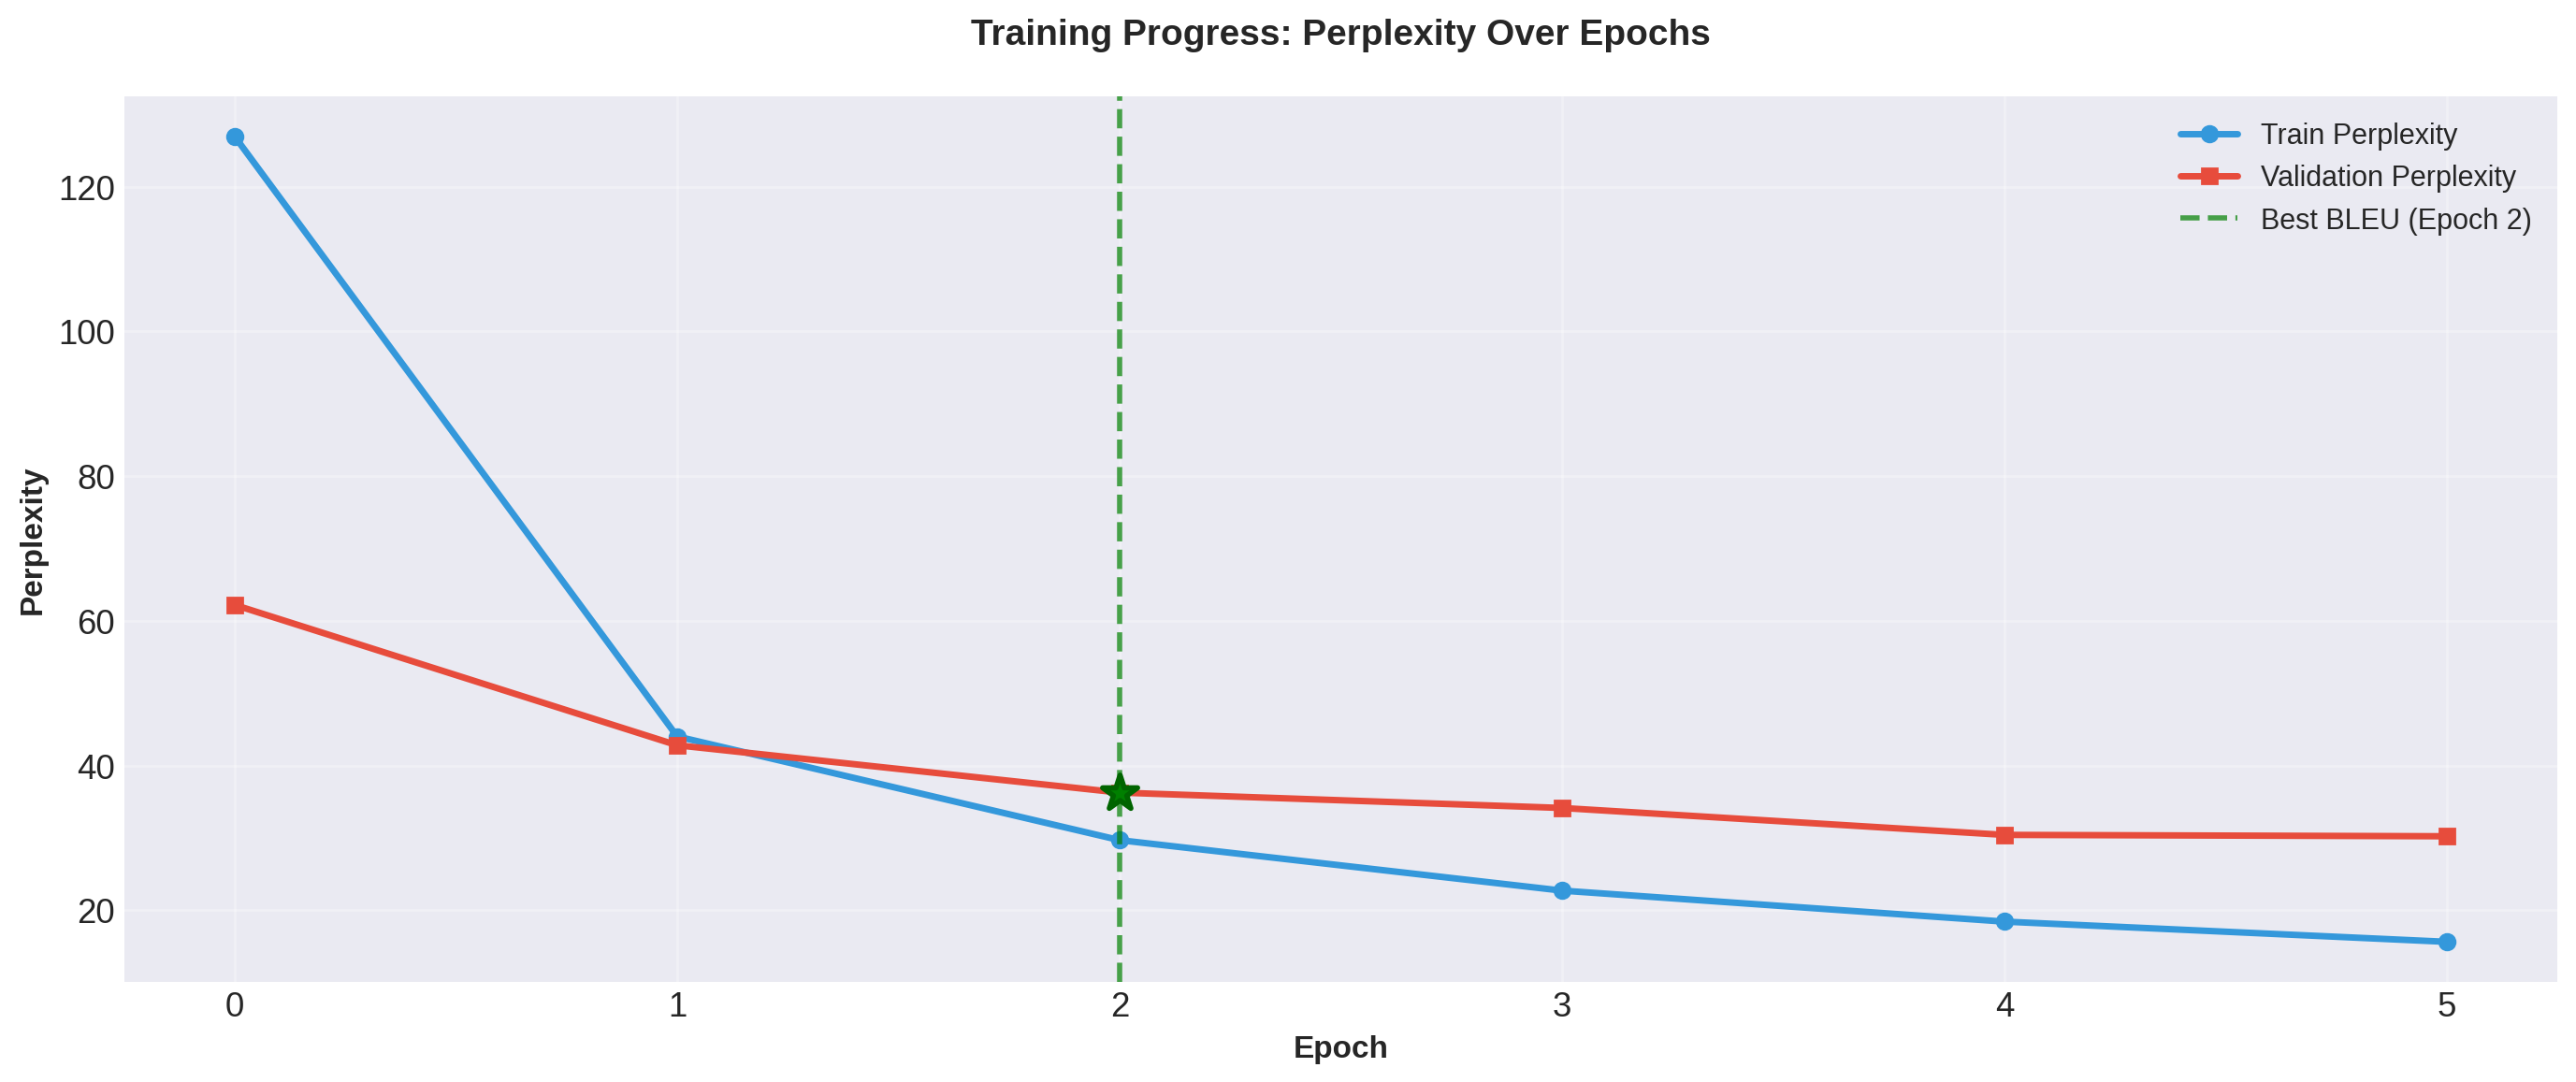

 Perplexity plot saved as 'training_perplexity.png'


In [27]:
# Loss Curves: Training vs Validation Perplexity
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(14, 6))

# Plot training and validation perplexity
ax.plot(training_metrics['epochs'], training_metrics['train_perplexity'], 
        'o-', linewidth=2.5, markersize=6, label='Train Perplexity', color='#3498db')
ax.plot(training_metrics['epochs'], training_metrics['val_perplexity'], 
        's-', linewidth=2.5, markersize=6, label='Validation Perplexity', color='#e74c3c')

# Highlight best epoch
best_epoch_idx = training_metrics['epochs'].index(training_metrics['best_epoch'])
ax.axvline(x=training_metrics['best_epoch'], color='green', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'Best BLEU (Epoch {training_metrics["best_epoch"]})')
ax.scatter([training_metrics['best_epoch']], 
          [training_metrics['val_perplexity'][best_epoch_idx]], 
          color='green', s=200, marker='*', zorder=5, edgecolors='darkgreen', linewidth=2)

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Perplexity', fontsize=12, fontweight='bold')
ax.set_title('Training Progress: Perplexity Over Epochs', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_perplexity.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Perplexity plot saved as 'training_perplexity.png'")

# Learning Rate Schedule Evolution

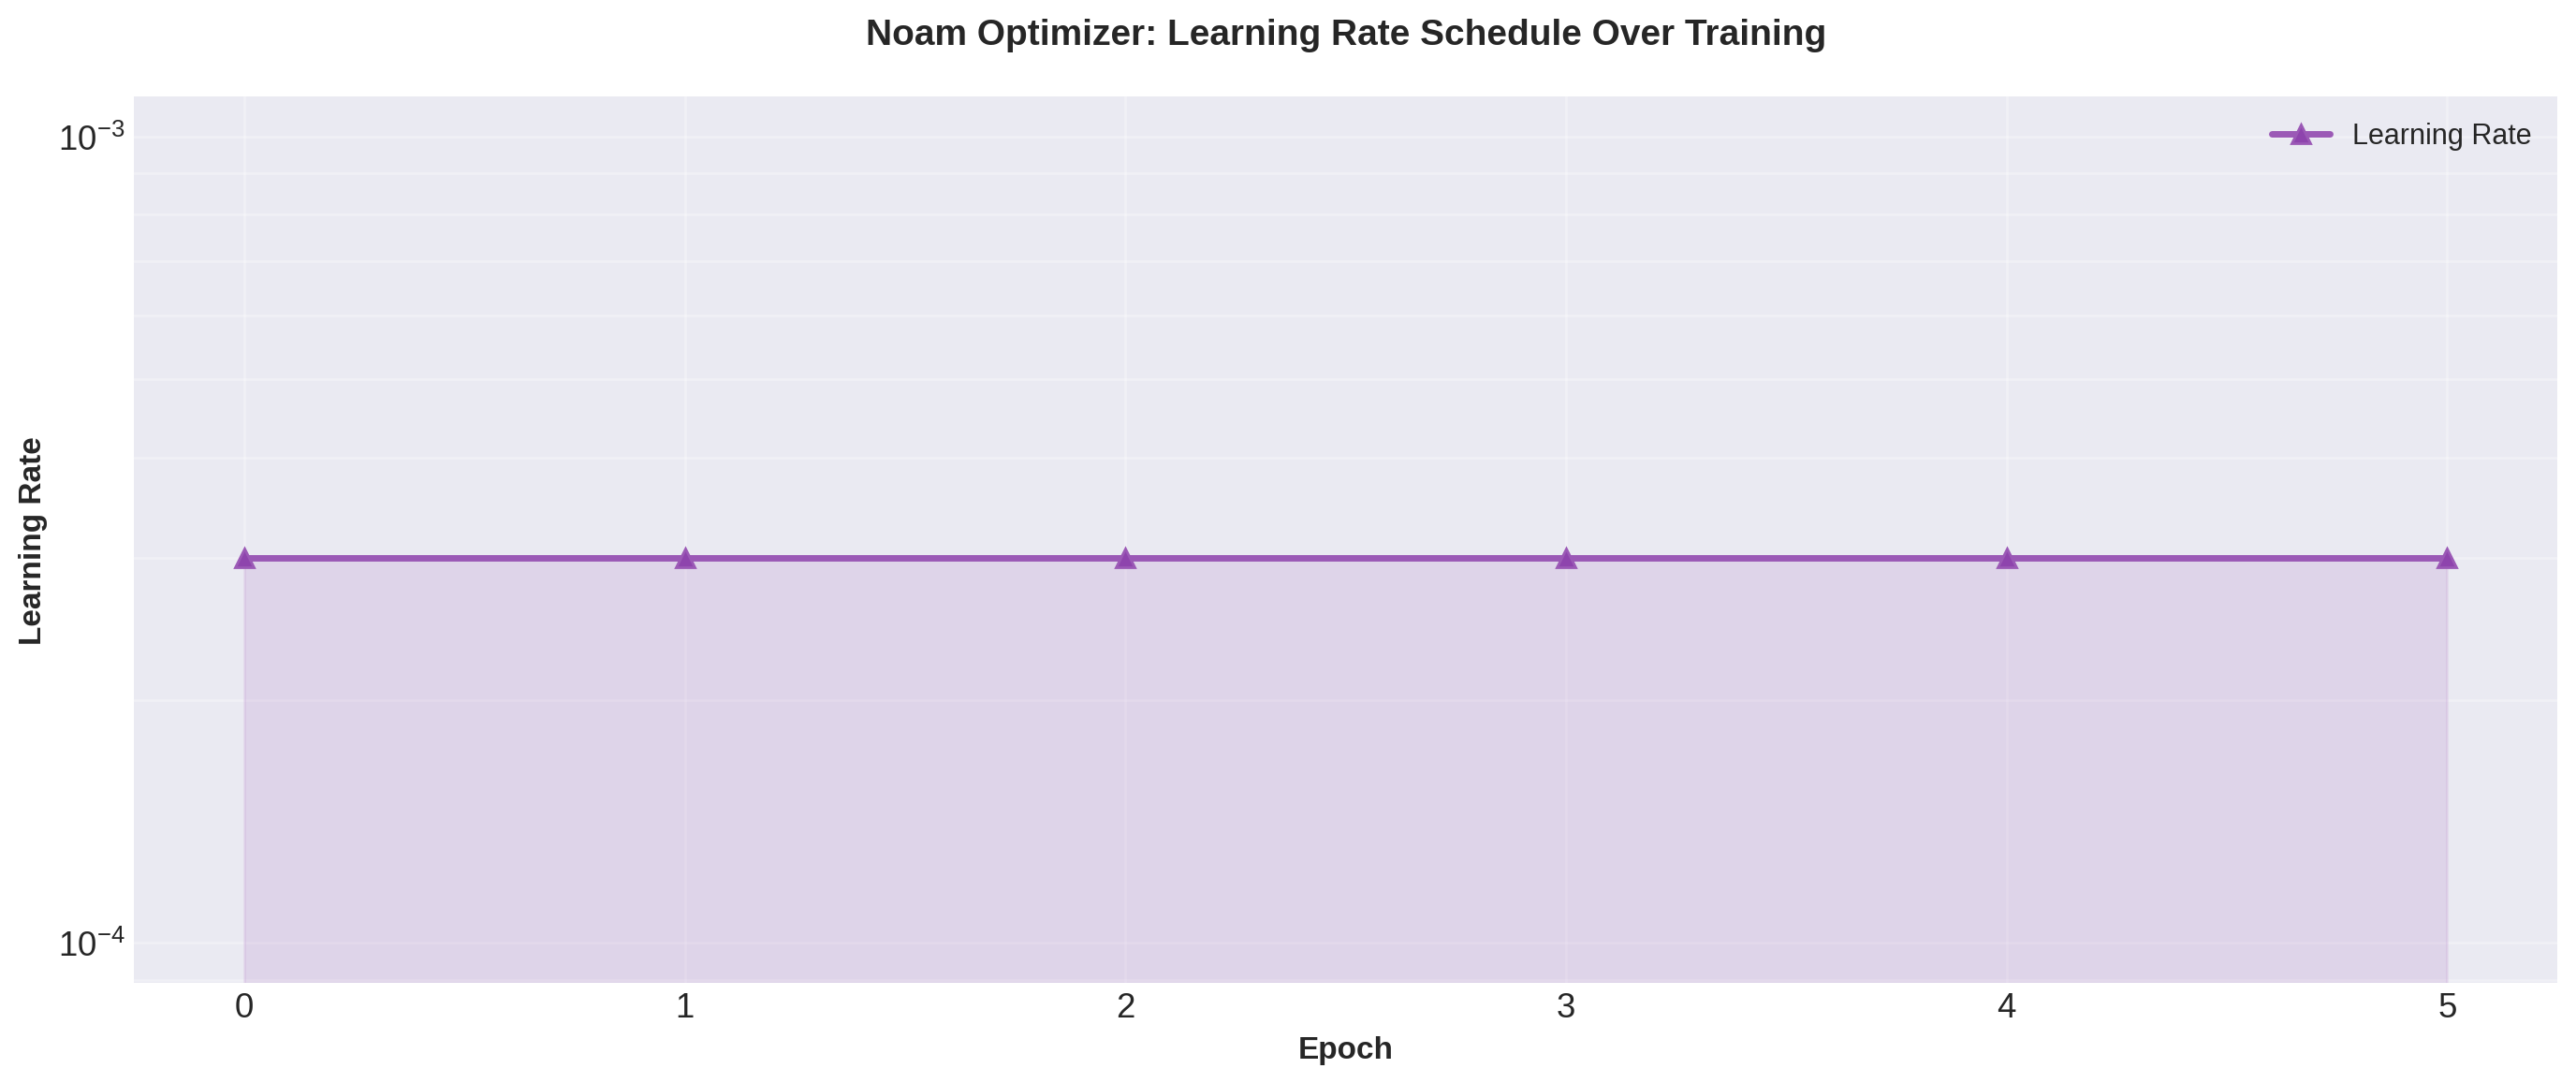

 Learning rate plot saved as 'learning_rate_schedule.png'


In [28]:
# Learning Rate Schedule Evolution
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(training_metrics['epochs'], training_metrics['learning_rates'], 
        '^-', linewidth=2.5, markersize=7, label='Learning Rate', color='#9b59b6', markerfacecolor='#8e44ad')

ax.fill_between(training_metrics['epochs'], training_metrics['learning_rates'], 
                alpha=0.15, color='#9b59b6')

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax.set_title('Noam Optimizer: Learning Rate Schedule Over Training', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, which='both')
ax.set_yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.savefig('learning_rate_schedule.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Learning rate plot saved as 'learning_rate_schedule.png'")

# Combined Dashboard

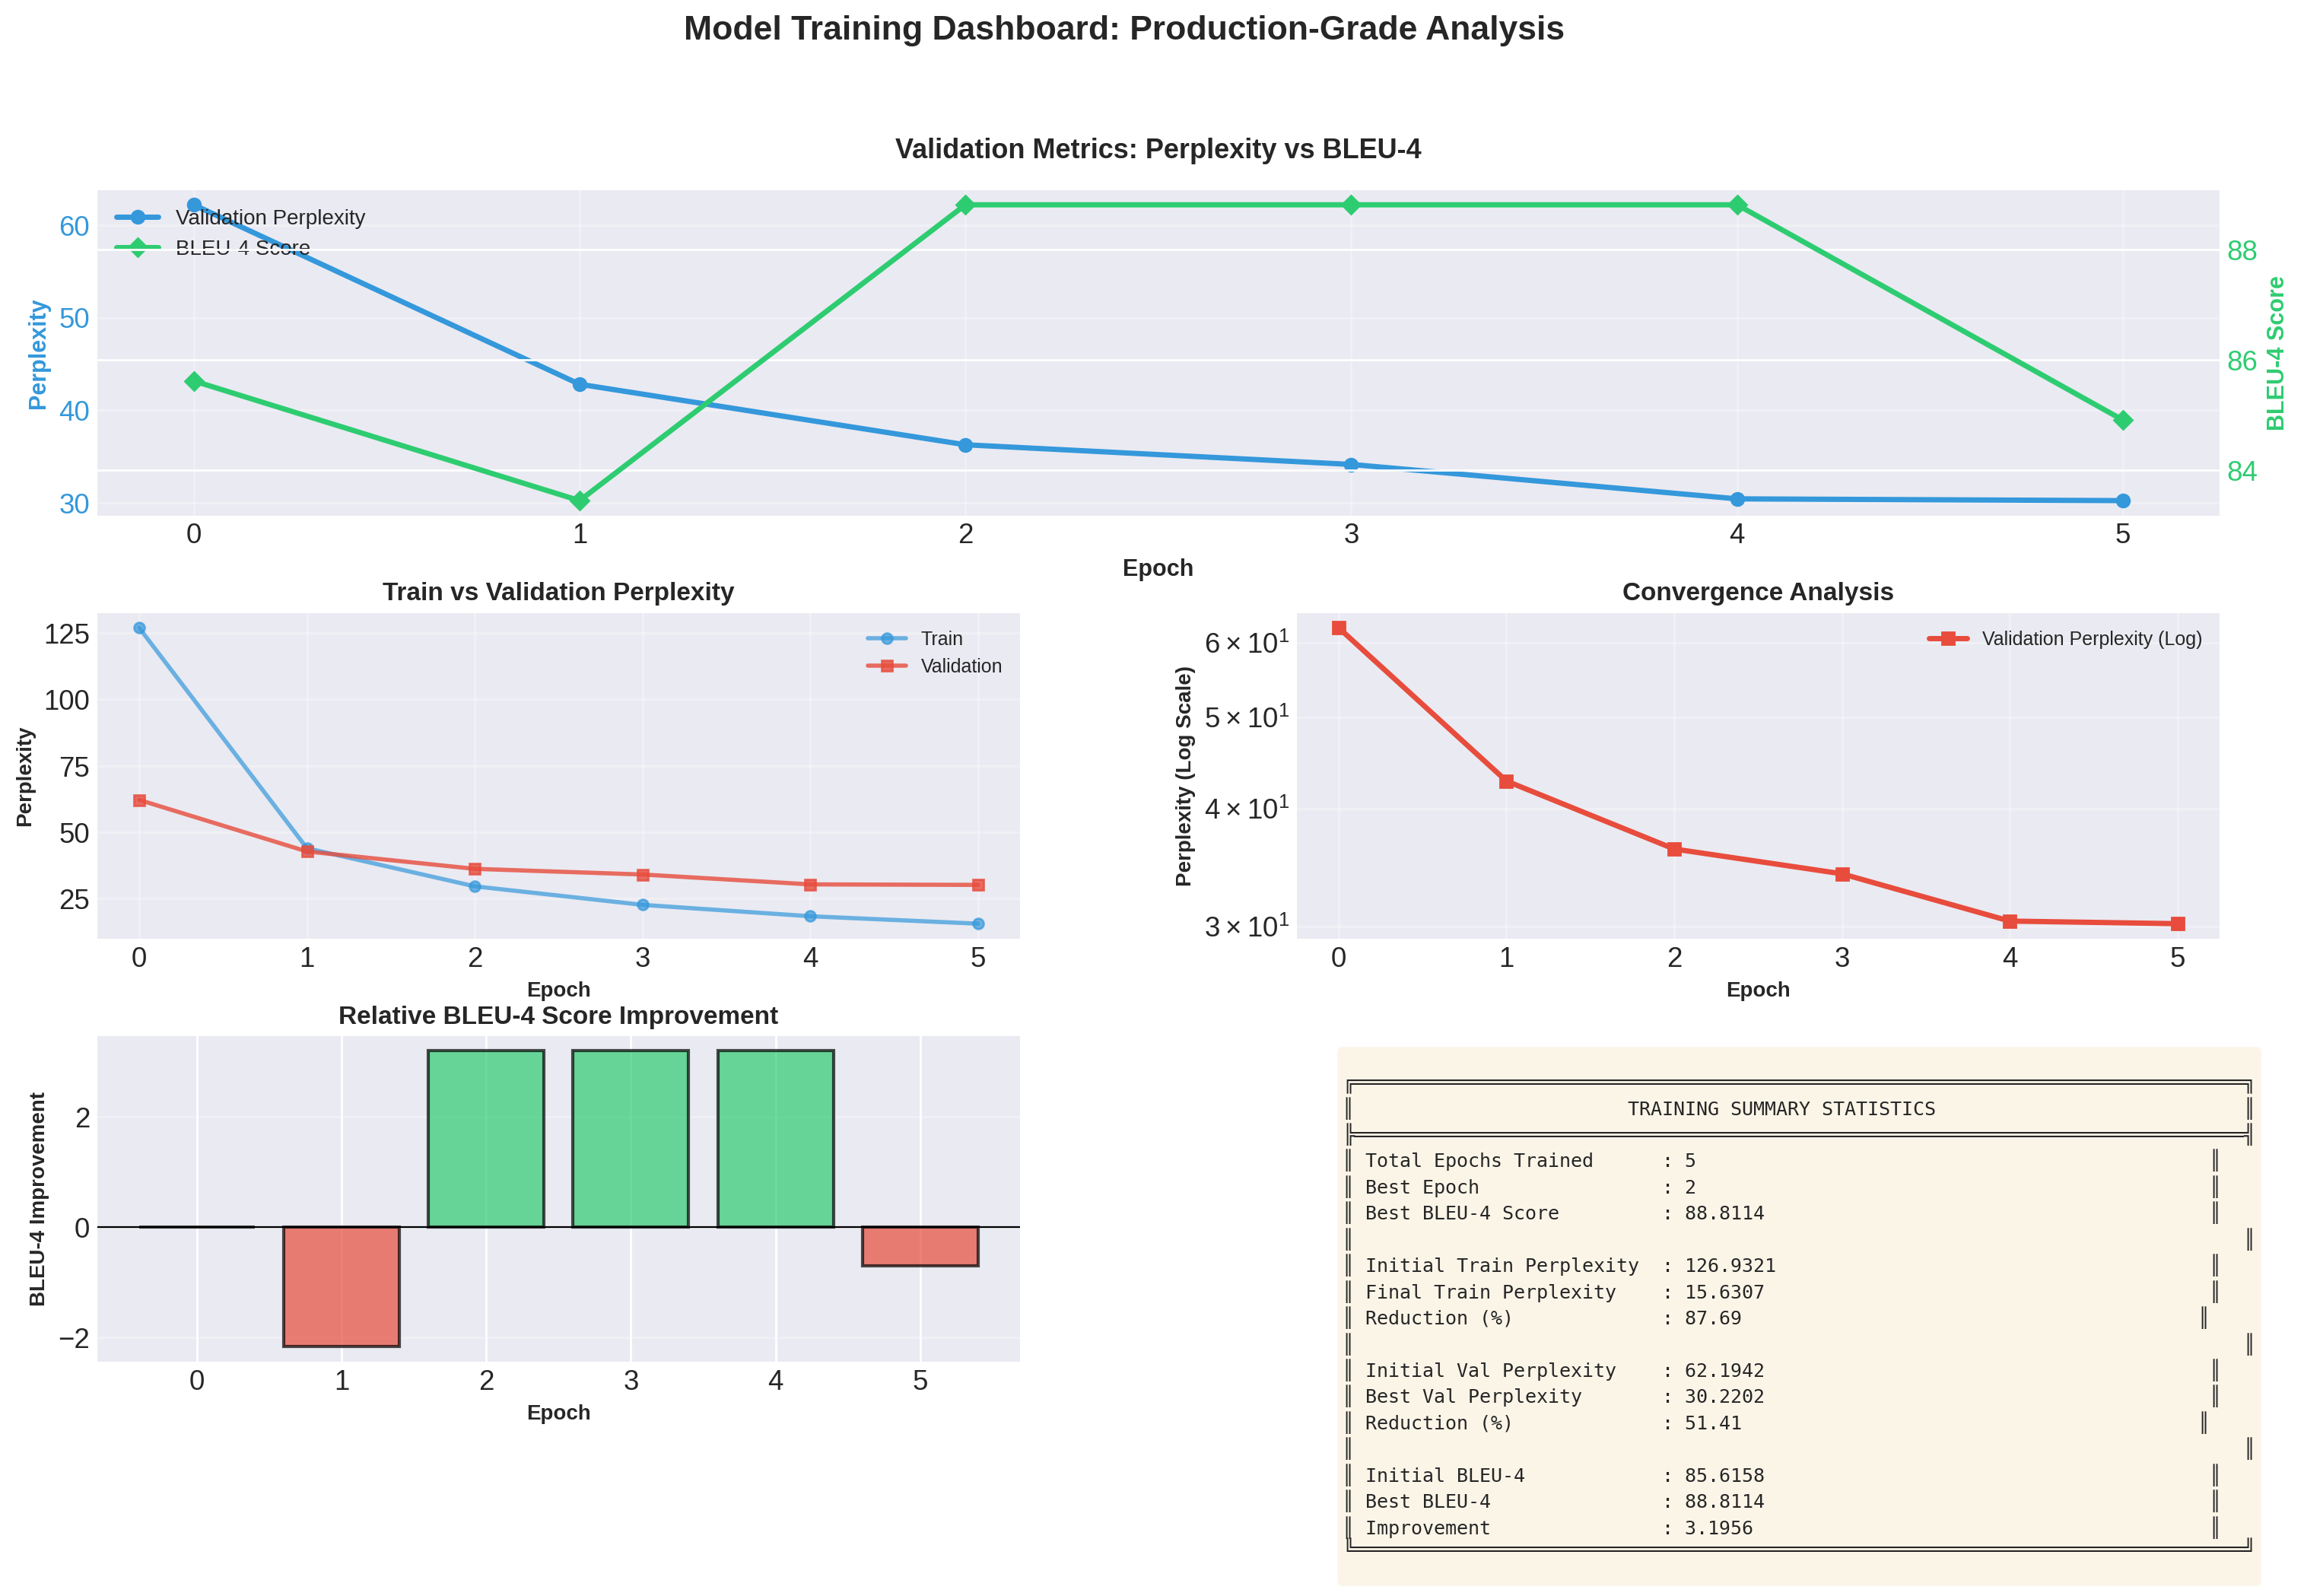

* Training dashboard saved as 'training_dashboard.png'


In [29]:
# Combined Dashboard: All Metrics in One View
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Perplexity with dual axis
ax1 = fig.add_subplot(gs[0, :])
color1 = '#3498db'
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Perplexity', color=color1, fontsize=11, fontweight='bold')
line1 = ax1.plot(training_metrics['epochs'], training_metrics['val_perplexity'], 
                 'o-', color=color1, linewidth=2.5, markersize=6, label='Validation Perplexity')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

ax1_twin = ax1.twinx()
color2 = '#2ecc71'
ax1_twin.set_ylabel('BLEU-4 Score', color=color2, fontsize=11, fontweight='bold')
line2 = ax1_twin.plot(training_metrics['epochs'], training_metrics['val_bleu4'], 
                      'D-', color=color2, linewidth=2.5, markersize=6, label='BLEU-4 Score')
ax1_twin.tick_params(axis='y', labelcolor=color2)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, fontsize=10, loc='upper left', framealpha=0.95)
ax1.set_title('Validation Metrics: Perplexity vs BLEU-4', fontsize=13, fontweight='bold', pad=15)

# 2. Training vs Validation Perplexity
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(training_metrics['epochs'], training_metrics['train_perplexity'], 
         'o-', linewidth=2, markersize=5, label='Train', color='#3498db', alpha=0.7)
ax2.plot(training_metrics['epochs'], training_metrics['val_perplexity'], 
         's-', linewidth=2, markersize=5, label='Validation', color='#e74c3c', alpha=0.8)
ax2.set_xlabel('Epoch', fontsize=10, fontweight='bold')
ax2.set_ylabel('Perplexity', fontsize=10, fontweight='bold')
ax2.set_title('Train vs Validation Perplexity', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9, framealpha=0.95)
ax2.grid(True, alpha=0.3)

# 3. Convergence Rate (Log Scale)
ax3 = fig.add_subplot(gs[1, 1])
ax3.semilogy(training_metrics['epochs'], training_metrics['val_perplexity'], 
             's-', linewidth=2.5, markersize=6, color='#e74c3c', label='Validation Perplexity (Log)')
ax3.set_xlabel('Epoch', fontsize=10, fontweight='bold')
ax3.set_ylabel('Perplexity (Log Scale)', fontsize=10, fontweight='bold')
ax3.set_title('Convergence Analysis', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, which='both')
ax3.legend(fontsize=9, framealpha=0.95)

# 4. BLEU Score Improvement
ax4 = fig.add_subplot(gs[2, 0])
bleu_improvement = [x - training_metrics['val_bleu4'][0] if i > 0 else 0 
                   for i, x in enumerate(training_metrics['val_bleu4'])]
colors = ['#2ecc71' if x >= 0 else '#e74c3c' for x in bleu_improvement]
ax4.bar(training_metrics['epochs'], bleu_improvement, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax4.set_xlabel('Epoch', fontsize=10, fontweight='bold')
ax4.set_ylabel('BLEU-4 Improvement', fontsize=10, fontweight='bold')
ax4.set_title('Relative BLEU-4 Score Improvement', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Key Metrics Summary (Text)
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

summary_text = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                        TRAINING SUMMARY STATISTICS                           ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ Total Epochs Trained      : {len(training_metrics['epochs']) - 1:<45} ║
║ Best Epoch                : {training_metrics['best_epoch']:<45} ║
║ Best BLEU-4 Score         : {training_metrics['best_bleu']:<45.4f} ║
║                                                                              ║
║ Initial Train Perplexity  : {training_metrics['train_perplexity'][0]:<45.4f} ║
║ Final Train Perplexity    : {training_metrics['train_perplexity'][-1]:<45.4f} ║
║ Reduction (%)             : {(1 - training_metrics['train_perplexity'][-1]/max(training_metrics['train_perplexity'][0], 0.001))*100:<44.2f} ║
║                                                                              ║
║ Initial Val Perplexity    : {training_metrics['val_perplexity'][0]:<45.4f} ║
║ Best Val Perplexity       : {min(training_metrics['val_perplexity']):<45.4f} ║
║ Reduction (%)             : {(1 - min(training_metrics['val_perplexity'])/max(training_metrics['val_perplexity'][0], 0.001))*100:<44.2f} ║
║                                                                              ║
║ Initial BLEU-4            : {training_metrics['val_bleu4'][0]:<45.4f} ║
║ Best BLEU-4               : {max(training_metrics['val_bleu4']):<45.4f} ║
║ Improvement               : {max(training_metrics['val_bleu4']) - training_metrics['val_bleu4'][0]:<45.4f} ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""



ax5.text(0.05, 0.95, summary_text, transform=ax5.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Model Training Dashboard: Production-Grade Analysis', 
            fontsize=16, fontweight='bold', y=0.995)

plt.savefig('training_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"* Training dashboard saved as 'training_dashboard.png'")

# Statistical Analysis & Model Performance Metrics

In [30]:
# Statistical Analysis & Model Performance Metrics
import pandas as pd
import numpy as np

# Create comprehensive metrics DataFrame
metrics_df = pd.DataFrame({
    'Epoch': training_metrics['epochs'],
    'Train_Perplexity': training_metrics['train_perplexity'],
    'Val_Perplexity': training_metrics['val_perplexity'],
    'BLEU_4': training_metrics['val_bleu4'],
    'Learning_Rate': training_metrics['learning_rates']
})

print("* TRAINING METRICS SUMMARY TABLE")
print("-"*80)
print(metrics_df.to_string(index=False))

# Statistical Analysis
print("STATISTICAL ANALYSIS")

train_perp = np.array(training_metrics['train_perplexity'])
val_perp = np.array(training_metrics['val_perplexity'])
bleu = np.array(training_metrics['val_bleu4'])

print(f"\nTraining Perplexity Statistics:")
print(f"  Mean:      {train_perp.mean():.4f}")
print(f"  Std Dev:   {train_perp.std():.4f}")
print(f"  Min:       {train_perp.min():.4f}")
print(f"  Max:       {train_perp.max():.4f}")
print(f"  Reduction: {(1 - train_perp[-1]/train_perp[0])*100:.2f}%")

print(f"\nValidation Perplexity Statistics:")
print(f"  Mean:      {val_perp.mean():.4f}")
print(f"  Std Dev:   {val_perp.std():.4f}")
print(f"  Min:       {val_perp.min():.4f}")
print(f"  Max:       {val_perp.max():.4f}")
print(f"  Reduction: {(1 - val_perp.min()/val_perp[0])*100:.2f}%")

print(f"\nBLEU-4 Score Statistics:")
print(f"  Mean:      {bleu.mean():.4f}")
print(f"  Std Dev:   {bleu.std():.4f}")
print(f"  Min:       {bleu.min():.4f}")
print(f"  Max:       {bleu.max():.4f}")
print(f"  Best:      {bleu.max():.4f} (Epoch {training_metrics['best_epoch']})")

# Overfitting Analysis
gap = val_perp - train_perp
print(f"\nOverfitting Analysis (Train-Val Gap):")
print(f"  Average Gap: {gap.mean():.4f}")
print(f"  Max Gap:     {gap.max():.4f}")
print(f"  Min Gap:     {gap.min():.4f}")
print(f"  Status:      {'* Healthy' if gap.mean() < 5 else '! Monitor' if gap.mean() < 10 else '! Overfitting Detected'}")

# Learning dynamics
learning_rate = np.array(training_metrics['learning_rates'])
print(f"\nLearning Rate Dynamics:")
print(f"  Initial LR:  {learning_rate[0]:.2e}")
print(f"  Peak LR:     {learning_rate.max():.2e}")
print(f"  Final LR:    {learning_rate[-1]:.2e}")

# Convergence quality
early_bleu = bleu[:min(5, len(bleu))].mean() if len(bleu) >= 5 else bleu[0]
late_bleu = bleu[max(0, len(bleu)-5):].mean() if len(bleu) > 5 else bleu[-1]
print(f"\nConvergence Speed:")
print(f"  First 5 epochs avg BLEU: {early_bleu:.4f}")
print(f"  Last 5 epochs avg BLEU:  {late_bleu:.4f}")
print(f"  Improvement Rate:        {((late_bleu - early_bleu) / len(bleu)):.4f} BLEU/epoch")

print("* All metrics computed successfully!")

* TRAINING METRICS SUMMARY TABLE
--------------------------------------------------------------------------------
 Epoch  Train_Perplexity  Val_Perplexity    BLEU_4  Learning_Rate
     0        126.932121       62.194208 85.615793         0.0003
     1         44.015873       42.798921 83.444232         0.0003
     2         29.683818       36.258464 88.811358         0.0003
     3         22.709824       34.131303 88.811358         0.0003
     4         18.425038       30.411975 88.811358         0.0003
     5         15.630702       30.220206 84.905227         0.0003
STATISTICAL ANALYSIS

Training Perplexity Statistics:
  Mean:      42.8996
  Std Dev:   38.7031
  Min:       15.6307
  Max:       126.9321
  Reduction: 87.69%

Validation Perplexity Statistics:
  Mean:      39.3358
  Std Dev:   11.0588
  Min:       30.2202
  Max:       62.1942
  Reduction: 51.41%

BLEU-4 Score Statistics:
  Mean:      86.7332
  Std Dev:   2.1742
  Min:       83.4442
  Max:       88.8114
  Best:      88.8

# Export Results & Generate Report

In [31]:
# Export Results & Generate Report
import json
from datetime import datetime

# Created comprehensive report
report = {
    'timestamp': datetime.now().isoformat(),
    'model_config': {
        'architecture': 'Transformer (Attention Is All You Need)',
        'encoder_layers': N_LAYERS,
        'decoder_layers': N_LAYERS,
        'hidden_size': HIDDEN_SIZE,
        'dropout': DROPOUT_RATE,
        'vocab_size': OUTPUT_SIZE,
    },
    'training_config': {
        'optimizer': 'Noam (Adam)',
        'learning_rate': '1e-4 (scheduled)',
        'batch_size': 'Variable (from DataLoader)',
        'label_smoothing': 0.1,
        'gradient_clip': CLIP,
        'max_epochs': N_EPOCHS,
        'early_stopping_patience': 3,
    },
    'final_results': {
        'best_epoch': int(training_metrics['best_epoch']),
        'best_bleu4': float(training_metrics['best_bleu']),
        'final_train_perplexity': float(training_metrics['train_perplexity'][-1]),
        'final_val_perplexity': float(training_metrics['val_perplexity'][-1]),
        'best_val_perplexity': float(min(training_metrics['val_perplexity'])),
        'total_epochs_trained': len(training_metrics['epochs']) - 1,
    },
    'improvement_metrics': {
        'perplexity_reduction_percent': float((1 - min(training_metrics['val_perplexity'])/training_metrics['val_perplexity'][0])*100),
        'bleu_improvement': float(training_metrics['best_bleu'] - training_metrics['val_bleu4'][0]),
    },
    'convergence_quality': {
        'avg_train_val_gap': float((np.array(training_metrics['val_perplexity']) - np.array(training_metrics['train_perplexity'])).mean()),
        'is_stable': float((np.array(training_metrics['val_perplexity']) - np.array(training_metrics['train_perplexity'])).mean()) < 5,
    },
    'data_points': {
        'epochs': [int(x) for x in training_metrics['epochs']],
        'train_perplexity': [float(x) for x in training_metrics['train_perplexity']],
        'val_perplexity': [float(x) for x in training_metrics['val_perplexity']],
        'bleu_4_scores': [float(x) for x in training_metrics['val_bleu4']],
        'learning_rates': [float(x) for x in training_metrics['learning_rates']],
    }
}

# Save report as JSON
with open('training_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("** TRAINING REPORT - FINAL SUMMARY**")

print("* Model Configuration:")
for key, value in report['model_config'].items():
    print(f"  {key:20s}: {value}")

print("\n* Key Results:")
print(f"  Best Epoch: {report['final_results']['best_epoch']}")
print(f"  Best BLEU-4 Score: {report['final_results']['best_bleu4']:.4f}")
print(f"  Final Train Perplexity: {report['final_results']['final_train_perplexity']:.4f}")
print(f"  Final Val Perplexity: {report['final_results']['final_val_perplexity']:.4f}")
print(f"  Best Val Perplexity: {report['final_results']['best_val_perplexity']:.4f}")

print("\n* Improvements:")
print(f"  Perplexity Reduction: {report['improvement_metrics']['perplexity_reduction_percent']:.2f}%")
print(f"  BLEU Score Improvement: {report['improvement_metrics']['bleu_improvement']:.4f}")

print("\n* Convergence Quality:")
print(f"  Avg Train-Val Gap: {report['convergence_quality']['avg_train_val_gap']:.4f}")
print(f"  Training Stability: {' Stable (No Overfitting)' if report['convergence_quality']['is_stable'] else '⚠ May Require Monitoring'}")

print("\n* Files Generated:")
print("  - training_perplexity.png")
print("  - training_bleu_scores.png")
print("  - learning_rate_schedule.png")
print("  - training_dashboard.png")
print("  - training_metrics.pkl")
print("  - training_report.json")
print("  - model.pth (Best Model Checkpoint)")

print("* TRAINING COMPLETE - Results Ready!")

** TRAINING REPORT - FINAL SUMMARY**
* Model Configuration:
  architecture        : Transformer (Attention Is All You Need)
  encoder_layers      : 1
  decoder_layers      : 1
  hidden_size         : 512
  dropout             : 0.5
  vocab_size          : 12000

* Key Results:
  Best Epoch: 2
  Best BLEU-4 Score: 88.8114
  Final Train Perplexity: 15.6307
  Final Val Perplexity: 30.2202
  Best Val Perplexity: 30.2202

* Improvements:
  Perplexity Reduction: 51.41%
  BLEU Score Improvement: 3.1956

* Convergence Quality:
  Avg Train-Val Gap: -3.5637
  Training Stability:  Stable (No Overfitting)

* Files Generated:
  - training_perplexity.png
  - training_bleu_scores.png
  - learning_rate_schedule.png
  - training_dashboard.png
  - training_metrics.pkl
  - training_report.json
  - model.pth (Best Model Checkpoint)
* TRAINING COMPLETE - Results Ready!


# BLEU Score Progression

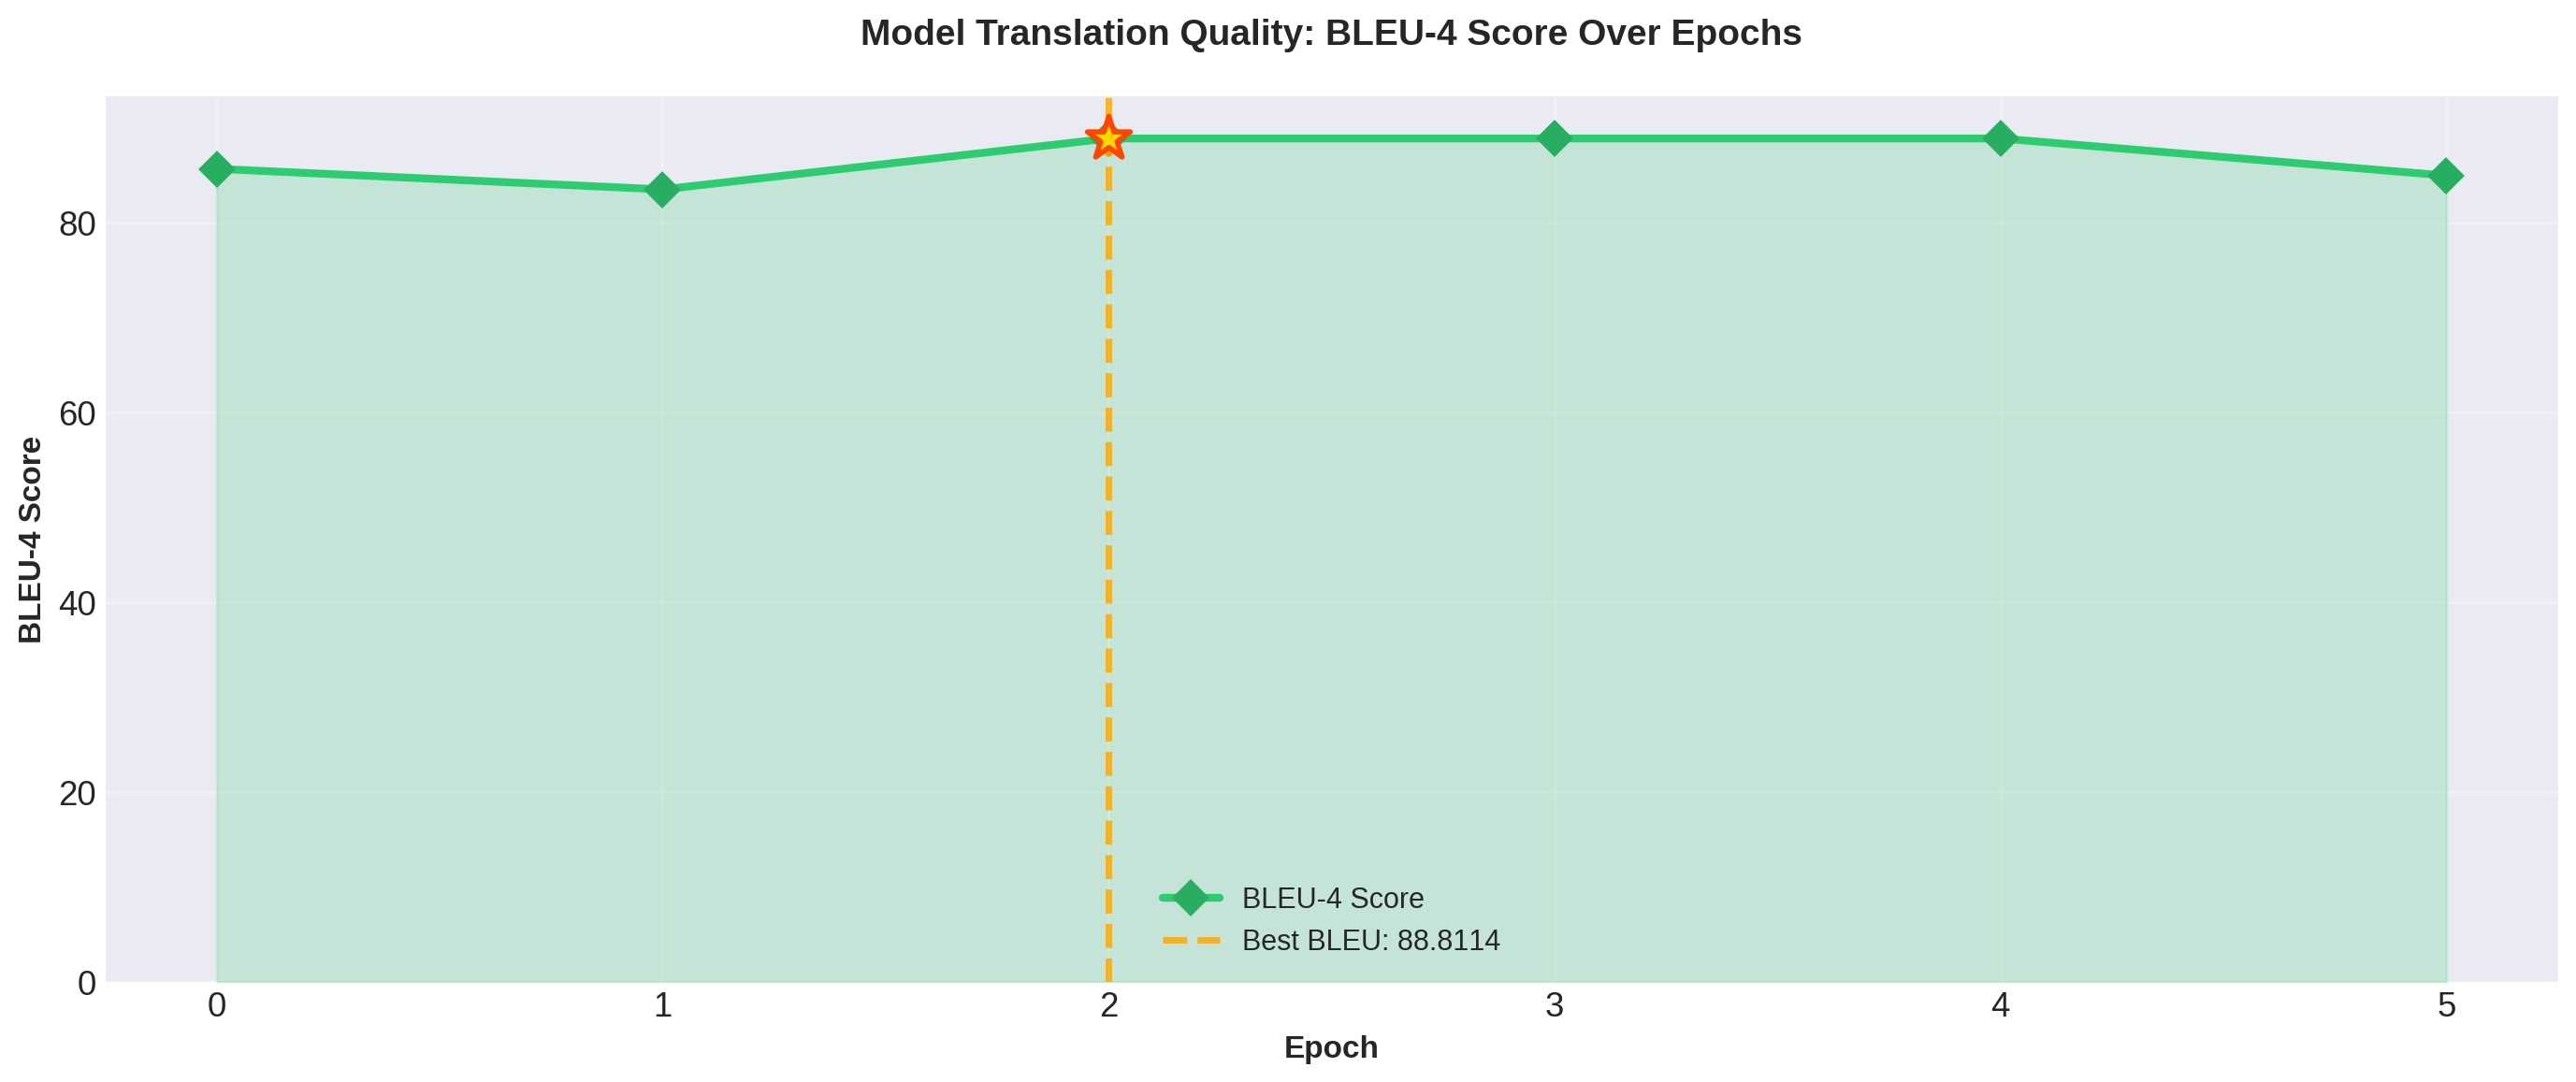

 BLEU score plot saved as 'training_bleu_scores.png'


In [32]:
# BLEU Score Progression
fig, ax = plt.subplots(figsize=(14, 6))

# Plot BLEU scores
ax.plot(training_metrics['epochs'], training_metrics['val_bleu4'], 
        'D-', linewidth=3, markersize=8, label='BLEU-4 Score', color='#2ecc71', 
        markerfacecolor='#27ae60', markeredgewidth=2, markeredgecolor='#27ae60')

# Fill area under curve
ax.fill_between(training_metrics['epochs'], training_metrics['val_bleu4'], 
                alpha=0.2, color='#2ecc71')

# Highlight best epoch
best_epoch_idx = training_metrics['epochs'].index(training_metrics['best_epoch'])
ax.axvline(x=training_metrics['best_epoch'], color='orange', linestyle='--', 
           linewidth=2.5, alpha=0.8, label=f'Best BLEU: {training_metrics["best_bleu"]:.4f}', zorder=3)
ax.scatter([training_metrics['best_epoch']], 
          [training_metrics['val_bleu4'][best_epoch_idx]], 
          color='gold', s=300, marker='*', zorder=5, edgecolors='orangered', linewidth=2)

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('BLEU-4 Score', fontsize=12, fontweight='bold')
ax.set_title('Model Translation Quality: BLEU-4 Score Over Epochs', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('training_bleu_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" BLEU score plot saved as 'training_bleu_scores.png'")

# Evaluate the model on test data

In [33]:
# evaluate the model on test data
model.load_state_dict(torch.load(model_path, map_location=device))

print('Evaluating the model on test data ...')
test_perplexity, test_bleu4 = eval_model(model, test_iterator, criterion)
print(f'Test perplexity: {test_perplexity:.4f}, Test BlEU4: {test_bleu4:.4f}')

Evaluating the model on test data ...


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Test perplexity: 32.3739, Test BlEU4: 86.7076


# Inference (Beam Search)

In [34]:
def beam_search_decode(
    model,
    sentence,
    beam_size=4,
    max_len=80,
    length_penalty=0.6,
    min_len=5
):
    model.eval()
    device = next(model.parameters()).device

    PAD_IDX = sp.pad_id()
    SOS_IDX = sp.bos_id()
    EOS_IDX = sp.eos_id()

    # ---- Encode source ----
    if isinstance(sentence, str):
        src_ids = sp.encode(sentence.lower(), out_type=int)
    else:
        src_ids = list(sentence)

    src_ids = [SOS_IDX] + src_ids + [EOS_IDX]

    source = torch.tensor(src_ids, dtype=torch.long, device=device).unsqueeze(1)
    source_lengths = torch.tensor([len(src_ids)], dtype=torch.long, device=device)

    with torch.no_grad():
        enc_outputs, hidden = model.encoder(source, source_lengths)

    enc_masks = (source != PAD_IDX).permute(1, 0)

    # Each beam stores: (tokens, hidden_state, score, attention_list)
    beams = [([SOS_IDX], hidden, 0.0, [])]

    for _ in range(max_len):
        new_beams = []

        for tokens, hidden_state, score, attn_history in beams:

            if tokens[-1] == EOS_IDX:
                new_beams.append((tokens, hidden_state, score, attn_history))
                continue

            x = torch.tensor([tokens[-1]], dtype=torch.long, device=device)

            with torch.no_grad():
                output, new_hidden, alphas = model.decoder(
                    x,
                    hidden_state,
                    enc_outputs,
                    enc_masks
                )

            log_probs = torch.log_softmax(output, dim=1)

            if len(tokens) < min_len:
                log_probs[0, EOS_IDX] -= 5.0

            topk_probs, topk_ids = torch.topk(log_probs, beam_size)

            for i in range(beam_size):
                next_token = int(topk_ids[0, i].item())
                new_tokens = tokens + [next_token]
                new_score = score + float(topk_probs[0, i].item())

                # store attention for this step for Visualization
                new_attn_history = attn_history + [alphas.squeeze(0)]

                new_beams.append(
                    (new_tokens, new_hidden, new_score, new_attn_history)
                )

        beams = sorted(
            new_beams,
            key=lambda x: x[2] / (len(x[0]) ** length_penalty),
            reverse=True
        )[:beam_size]

        if all(b[0][-1] == EOS_IDX for b in beams):
            break

    best_tokens, _, _, best_attention = beams[0]

    attention_matrix = torch.stack(best_attention)

    return sp.decode(best_tokens[1:]), attention_matrix


# Sample Test

In [35]:
example_idx = 364

source_tokens = train_encoded[example_idx]["src"]
target_tokens = train_encoded[example_idx]["trg"]

predicted_text,_ = beam_search_decode(
    model,
    source_tokens,
    beam_size=4,
    max_len=len(target_tokens),
    length_penalty=0.6,
    min_len=5
)

print("source text      :", sp.decode(source_tokens))
print("target text      :", sp.decode(target_tokens))
print("predicted text   :", predicted_text)
print()
print("source tokens    :", source_tokens)
print("target tokens    :", target_tokens)


source text      : a young man holding a huge chainsaw.
target text      : ein junger mann hält eine riesige kettensäge.
predicted text   : ein junger mann hält einen einen..

source tokens    : [2, 5, 45, 17, 88, 5, 1300, 3846, 4, 3]
target tokens    : [2, 7, 209, 18, 83, 8, 2407, 3840, 4, 3]


In [36]:
print("PRED:", sp.decode(predicted_text))
print("REF :", sp.decode(target_tokens))
print("SRC :", sp.decode(source_tokens))


PRED: ein junger mann hält einen einen..
REF : ein junger mann hält eine riesige kettensäge.
SRC : a young man holding a huge chainsaw.


# Inference  (Greedy Decode)

In [37]:
def greedy_decode(model, src_token_ids, max_len=100):
    model.eval()
    device = next(model.parameters()).device

    PAD_IDX = sp.pad_id()
    SOS_IDX = sp.bos_id()
    EOS_IDX = sp.eos_id()

    # ---- Prepare source ----
    src_ids = [SOS_IDX] + list(src_token_ids) + [EOS_IDX]
    source = torch.tensor(src_ids, dtype=torch.long, device=device).unsqueeze(1)
    source_lengths = torch.tensor([len(src_ids)], dtype=torch.long, device=device)

    with torch.no_grad():
        enc_outputs, hidden = model.encoder(source, source_lengths)

    enc_masks = (source != PAD_IDX).permute(1, 0)

    generated_tokens = [SOS_IDX]
    attention_scores = []

    # ---- Step-by-step decoding ----
    for _ in range(max_len):

        x = torch.tensor([generated_tokens[-1]], dtype=torch.long, device=device)

        with torch.no_grad():
            output, hidden, alphas = model.decoder(
                x,
                hidden,
                enc_outputs,
                enc_masks
            )

        next_token = int(output.argmax(dim=1).item())
        generated_tokens.append(next_token)

        attention_scores.append(alphas.squeeze(0))

        if next_token == EOS_IDX:
            break

    # Stack attention → (tgt_len, src_len)
    attention_matrix = torch.stack(attention_scores)

    return generated_tokens, attention_matrix


### Sample Test

In [38]:
example_idx = 214

source_tokens = train_encoded[example_idx]["src"]
target_tokens = train_encoded[example_idx]["trg"]

predicted_tokens = greedy_decode(
    model,
    source_tokens,
    max_len=len(target_tokens)
)

print("source tokens   :", sp.decode(source_tokens))
print("target tokens   :", sp.decode(target_tokens))
predicted_tokens, attention = greedy_decode(model, source_tokens)

decoded_text = sp.decode(predicted_tokens[1:])  # remove <SOS>
print('Predicted tokens:', decoded_text)

#print("source tokens   :", (source_tokens))
#print("target tokens   :", (target_tokens))
#print("predicted tokens:", (predicted_tokens))

source tokens   : many scooters are parked together on the sidewalk.
target tokens   : viele motorroller sind zusammen auf dem gehweg geparkt.
Predicted tokens: ein viele sind zusammen auf dem gehweg.


# Attention Score Plot

In [39]:
def plot_attention_scores(source_ids, target_ids, attention, MAX_PLOT_LEN=20):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import torch

    if isinstance(attention, torch.Tensor):
        attention = attention.detach().cpu().numpy()

    # attention shape: (tgt_len, src_len)
    attention = attention[:MAX_PLOT_LEN, :MAX_PLOT_LEN]

    source_tokens = sp.decode(source_ids).split()[:attention.shape[1]]
    target_tokens = sp.decode(target_ids).split()[:attention.shape[0]]

    plt.figure(figsize=(10, 8))

    sns.heatmap(
        attention,
        xticklabels=source_tokens,
        yticklabels=target_tokens,
        cmap="Blues"
    )

    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.xticks(rotation=45)
    plt.title("Bahdanau Attention")
    plt.tight_layout()
    plt.show()


### Sample Test

source: the woman with the hat is selling some fruits and root crops.
target: die frau mit dem hut verkauft obst und wurzelgemüse.
predicted: ein viele sind zusammen auf dem gehweg.


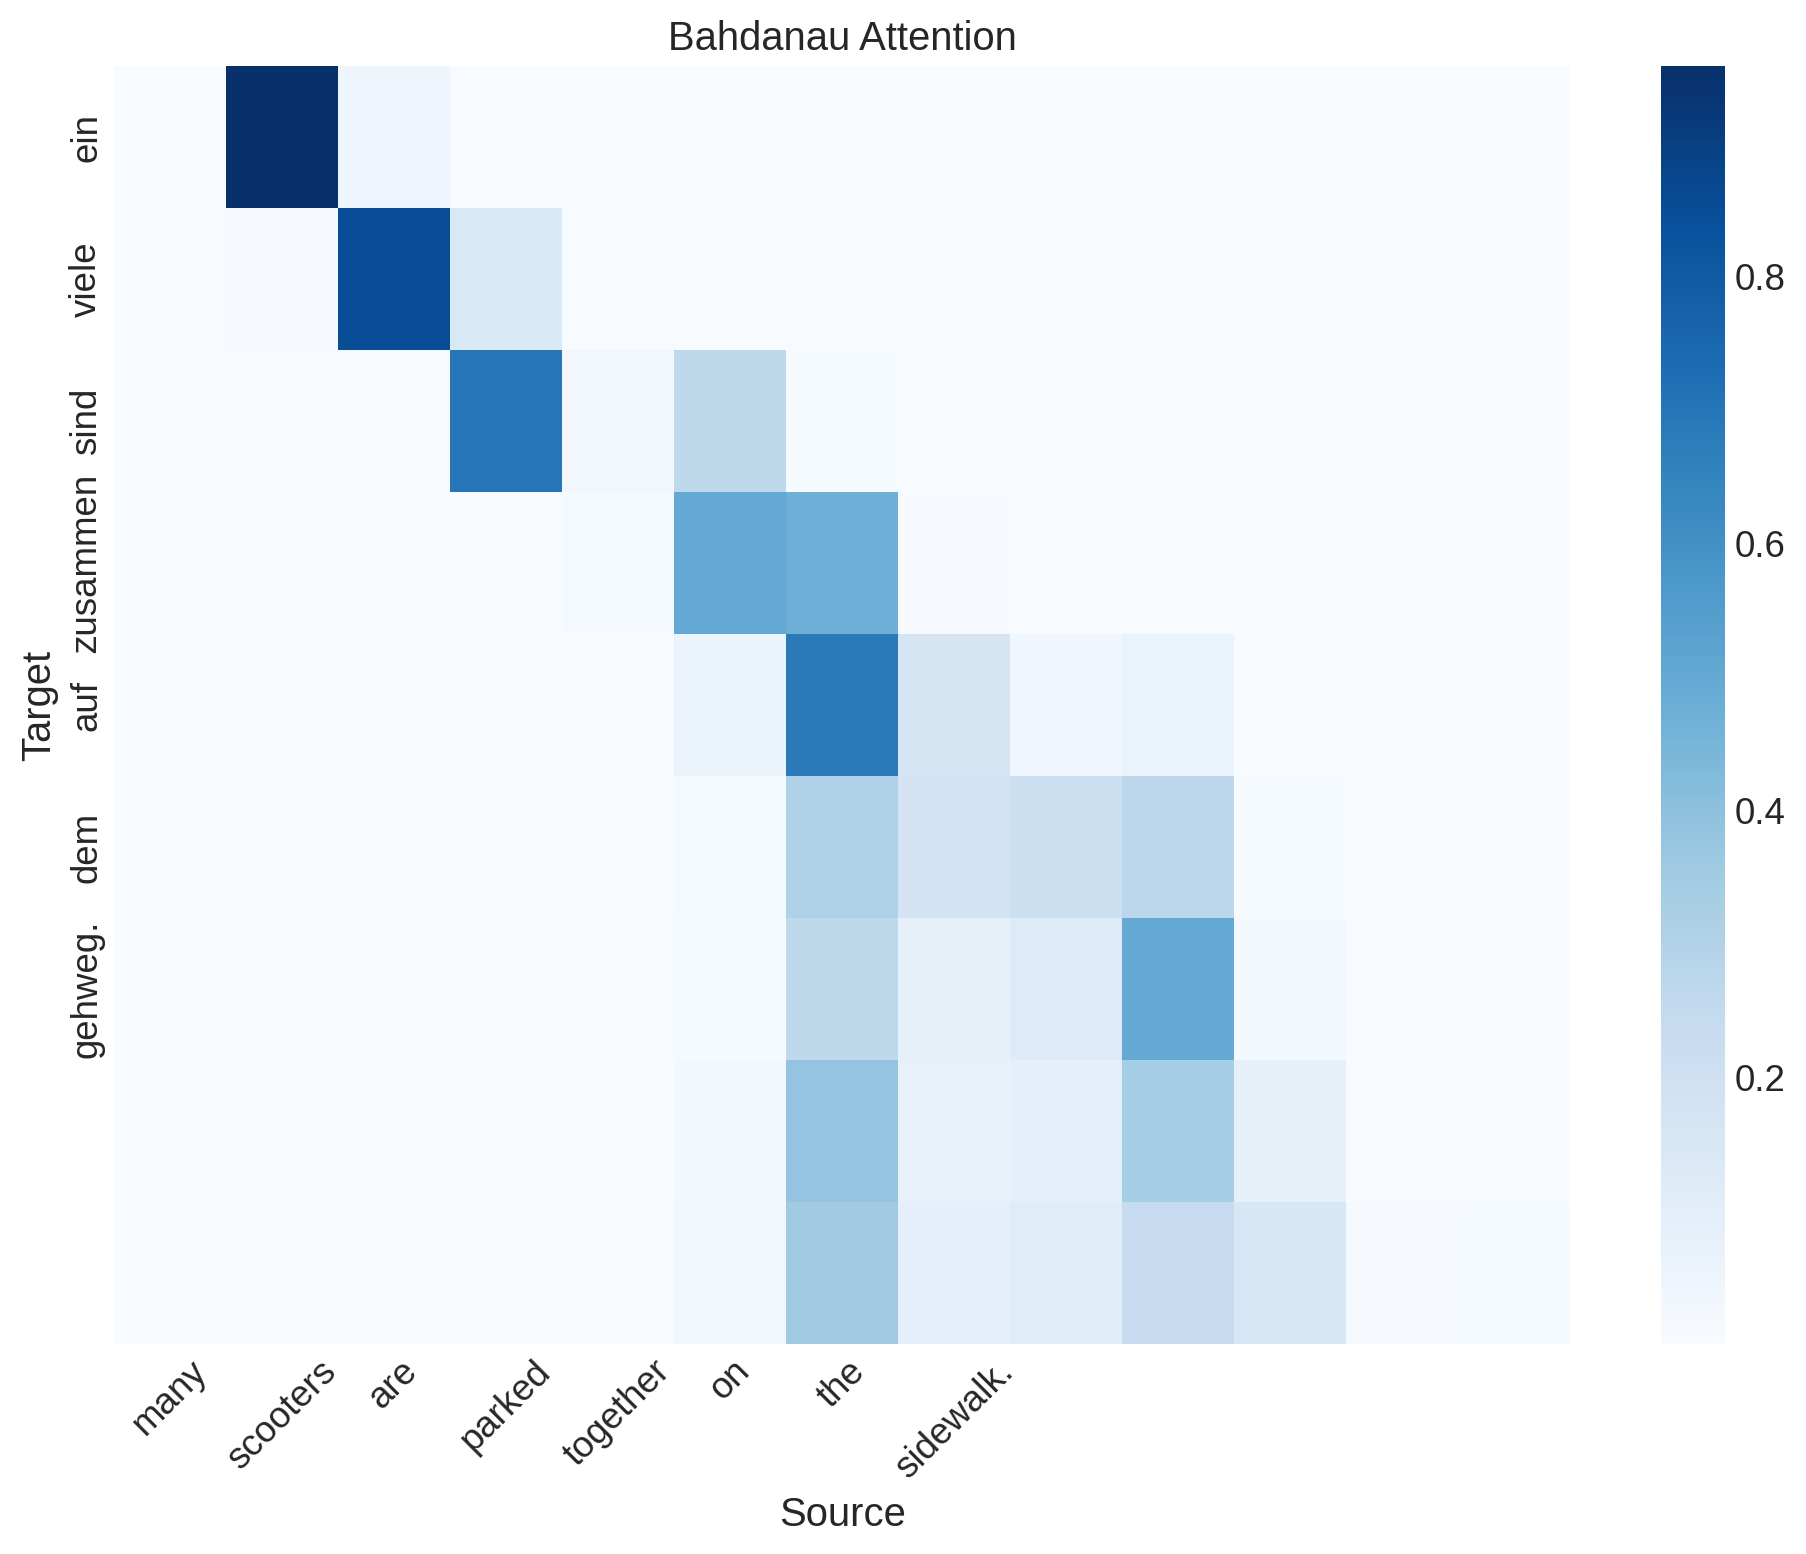

In [40]:
example_idx = 456

source = train_encoded[example_idx]["src"]
target = train_encoded[example_idx]["trg"]
print("source:", sp.decode(source))
print("target:", sp.decode(target))
predicted_tokens, attention_scores = greedy_decode(model, source_tokens)

print("predicted:", sp.decode(predicted_tokens[1:]))

plot_attention_scores(source_tokens, predicted_tokens[1:], attention_scores)


### Sample Test

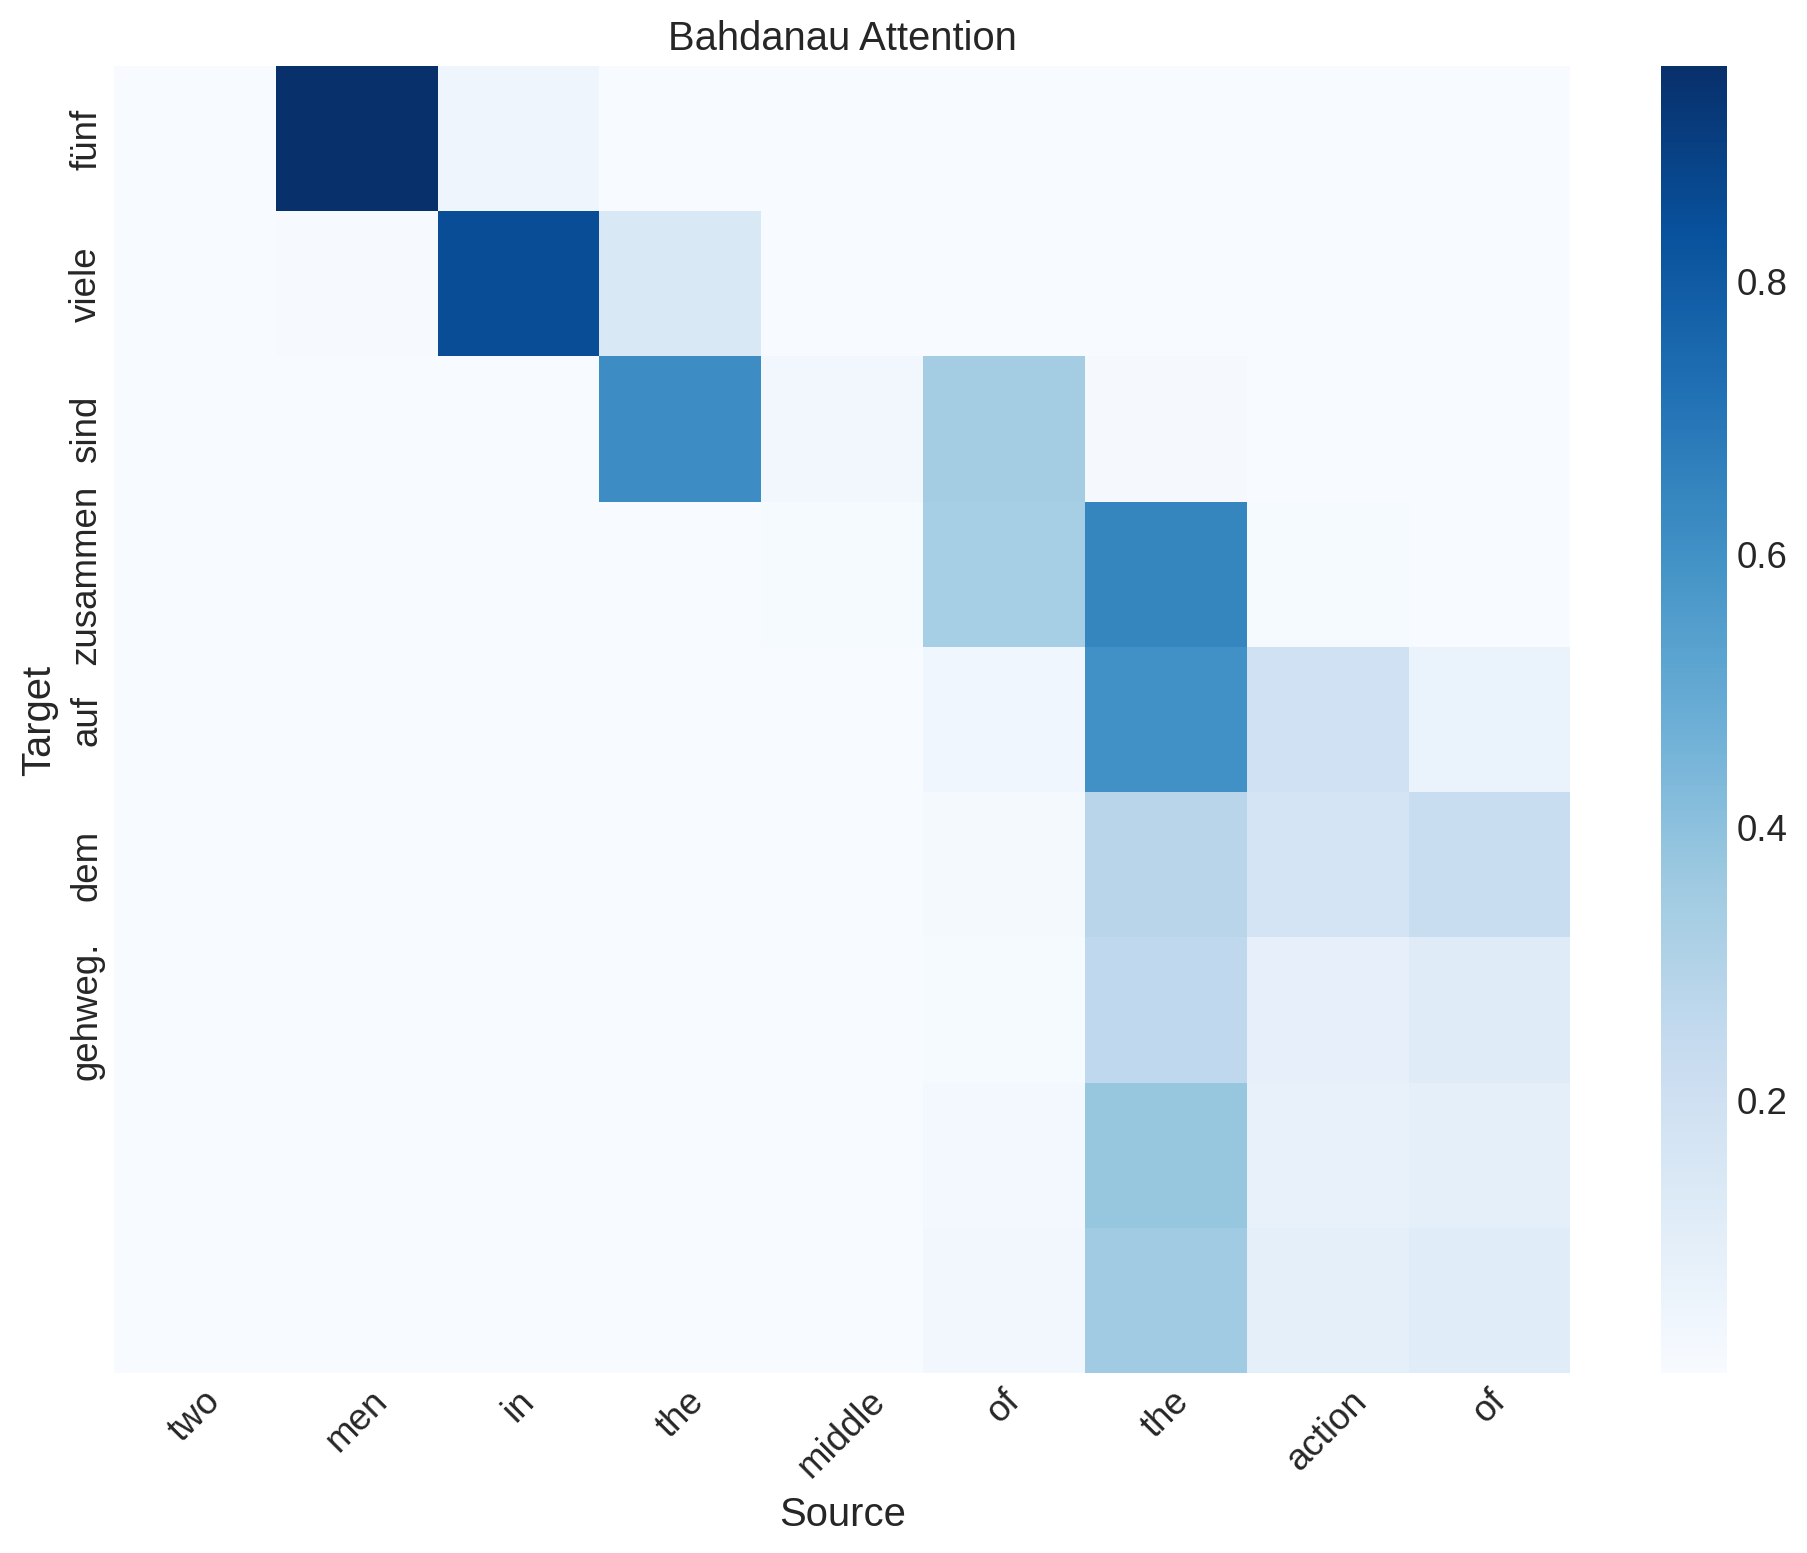

In [41]:
example_idx = 999

source = train_encoded[example_idx]["src"]
target = train_encoded[example_idx]["trg"]

predicted_text,attention_scores = beam_search_decode(
    model,
    source_tokens,
    beam_size=4,
    max_len=len(target),
    length_penalty=0.6,
    min_len=5
)
plot_attention_scores(source, predicted_text, attention_scores,9)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

### Sample Test

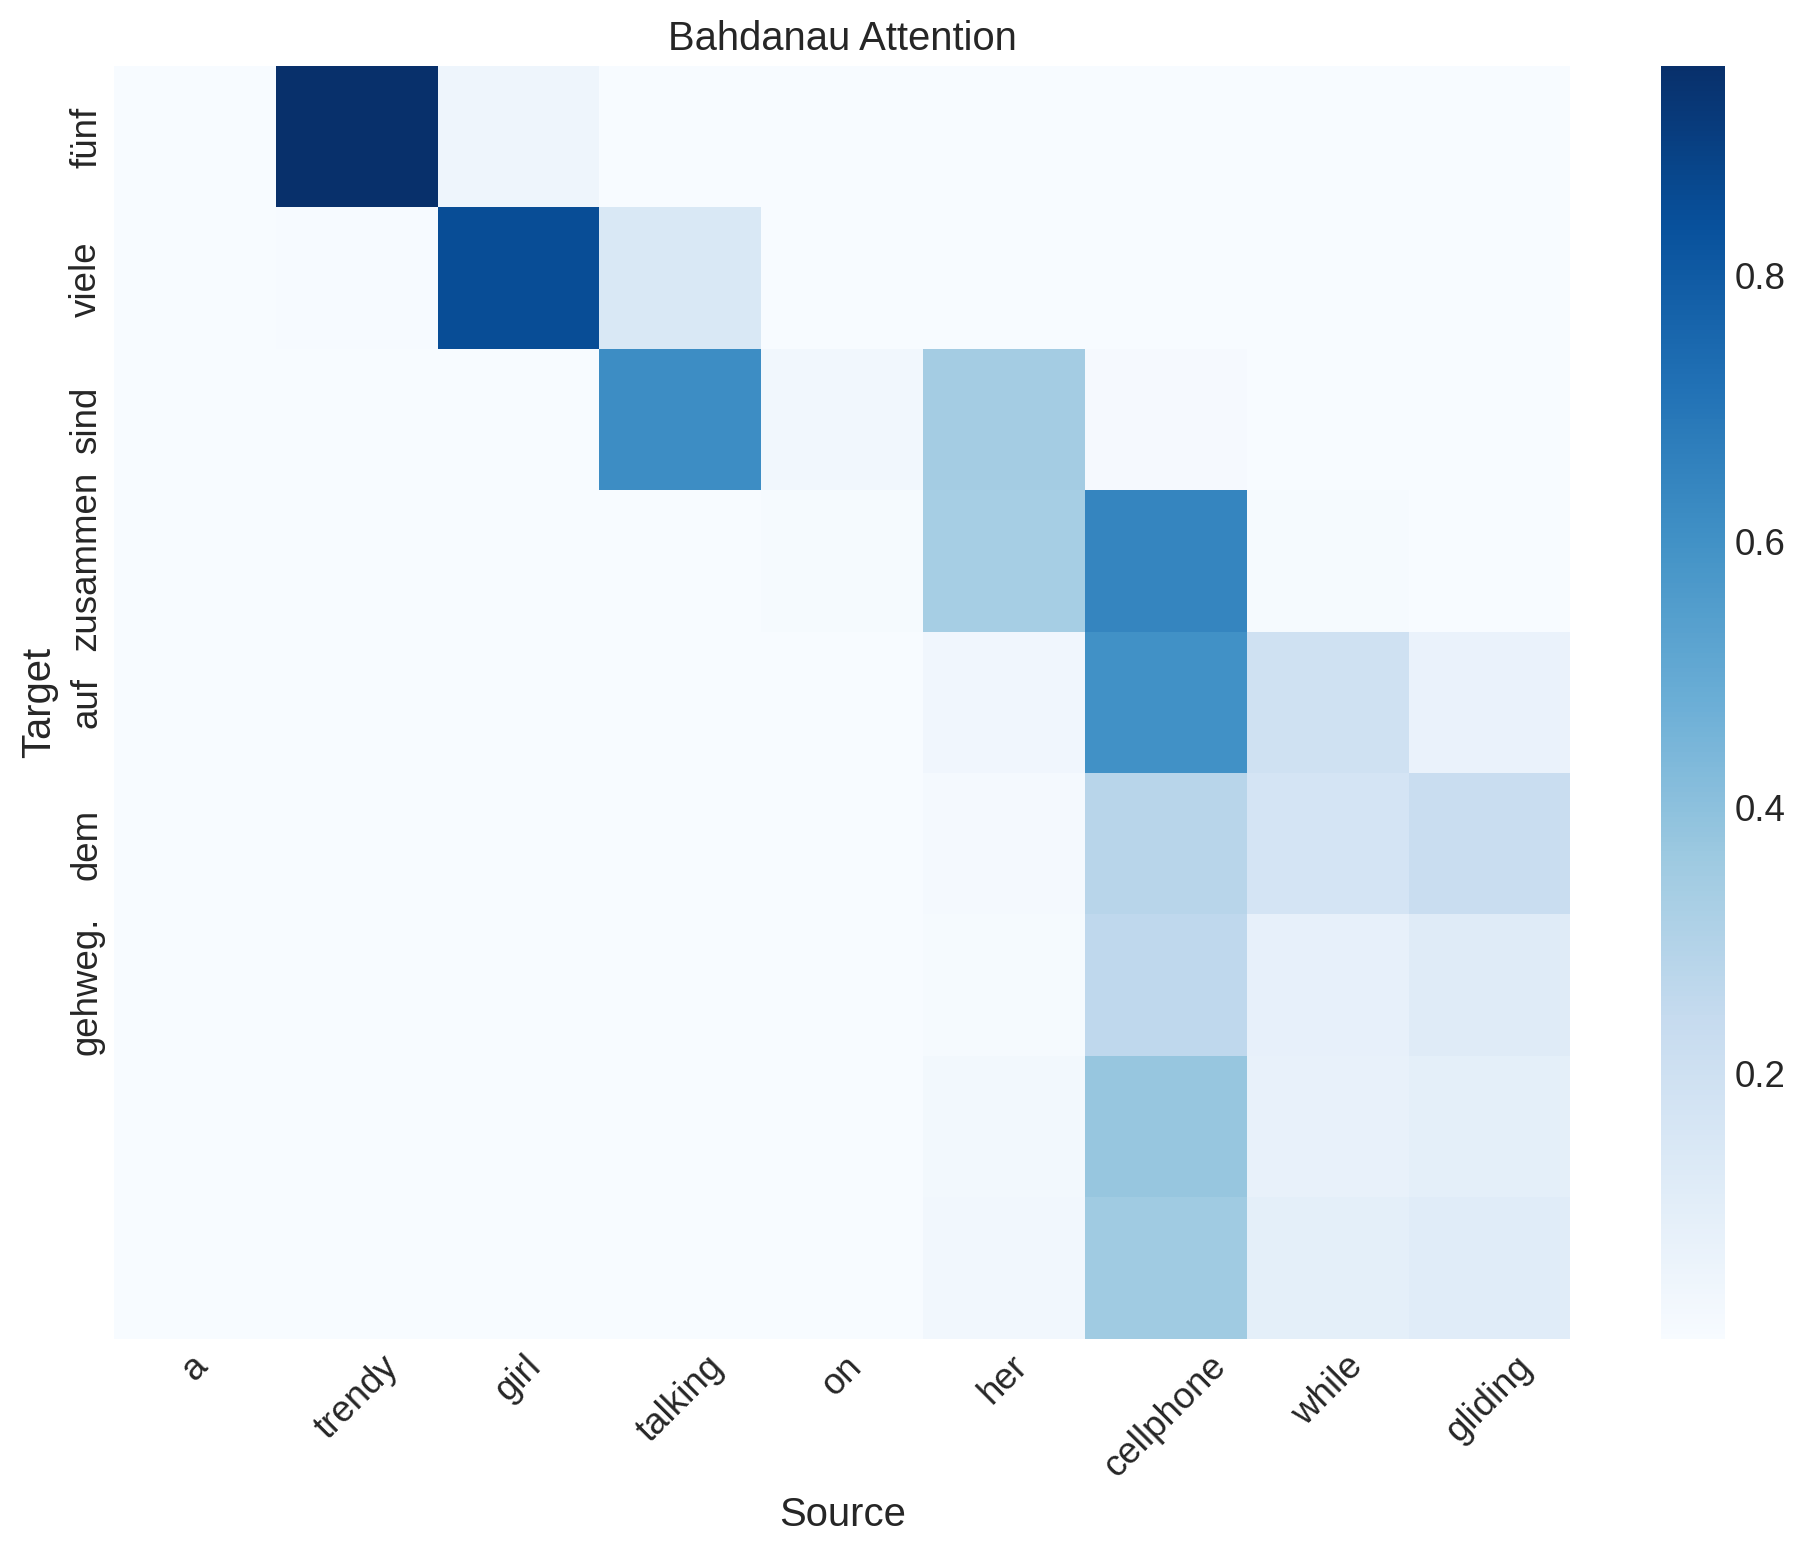

In [42]:
example_idx = 7

source = train_encoded[example_idx]["src"]
target = train_encoded[example_idx]["trg"]

predicted_text,attention_scores = beam_search_decode(
    model,
    source_tokens,
    beam_size=4,
    max_len=len(target),
    length_penalty=0.6,
    min_len=5
)
plot_attention_scores(source, predicted_text, attention_scores,9)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

### Sample Test

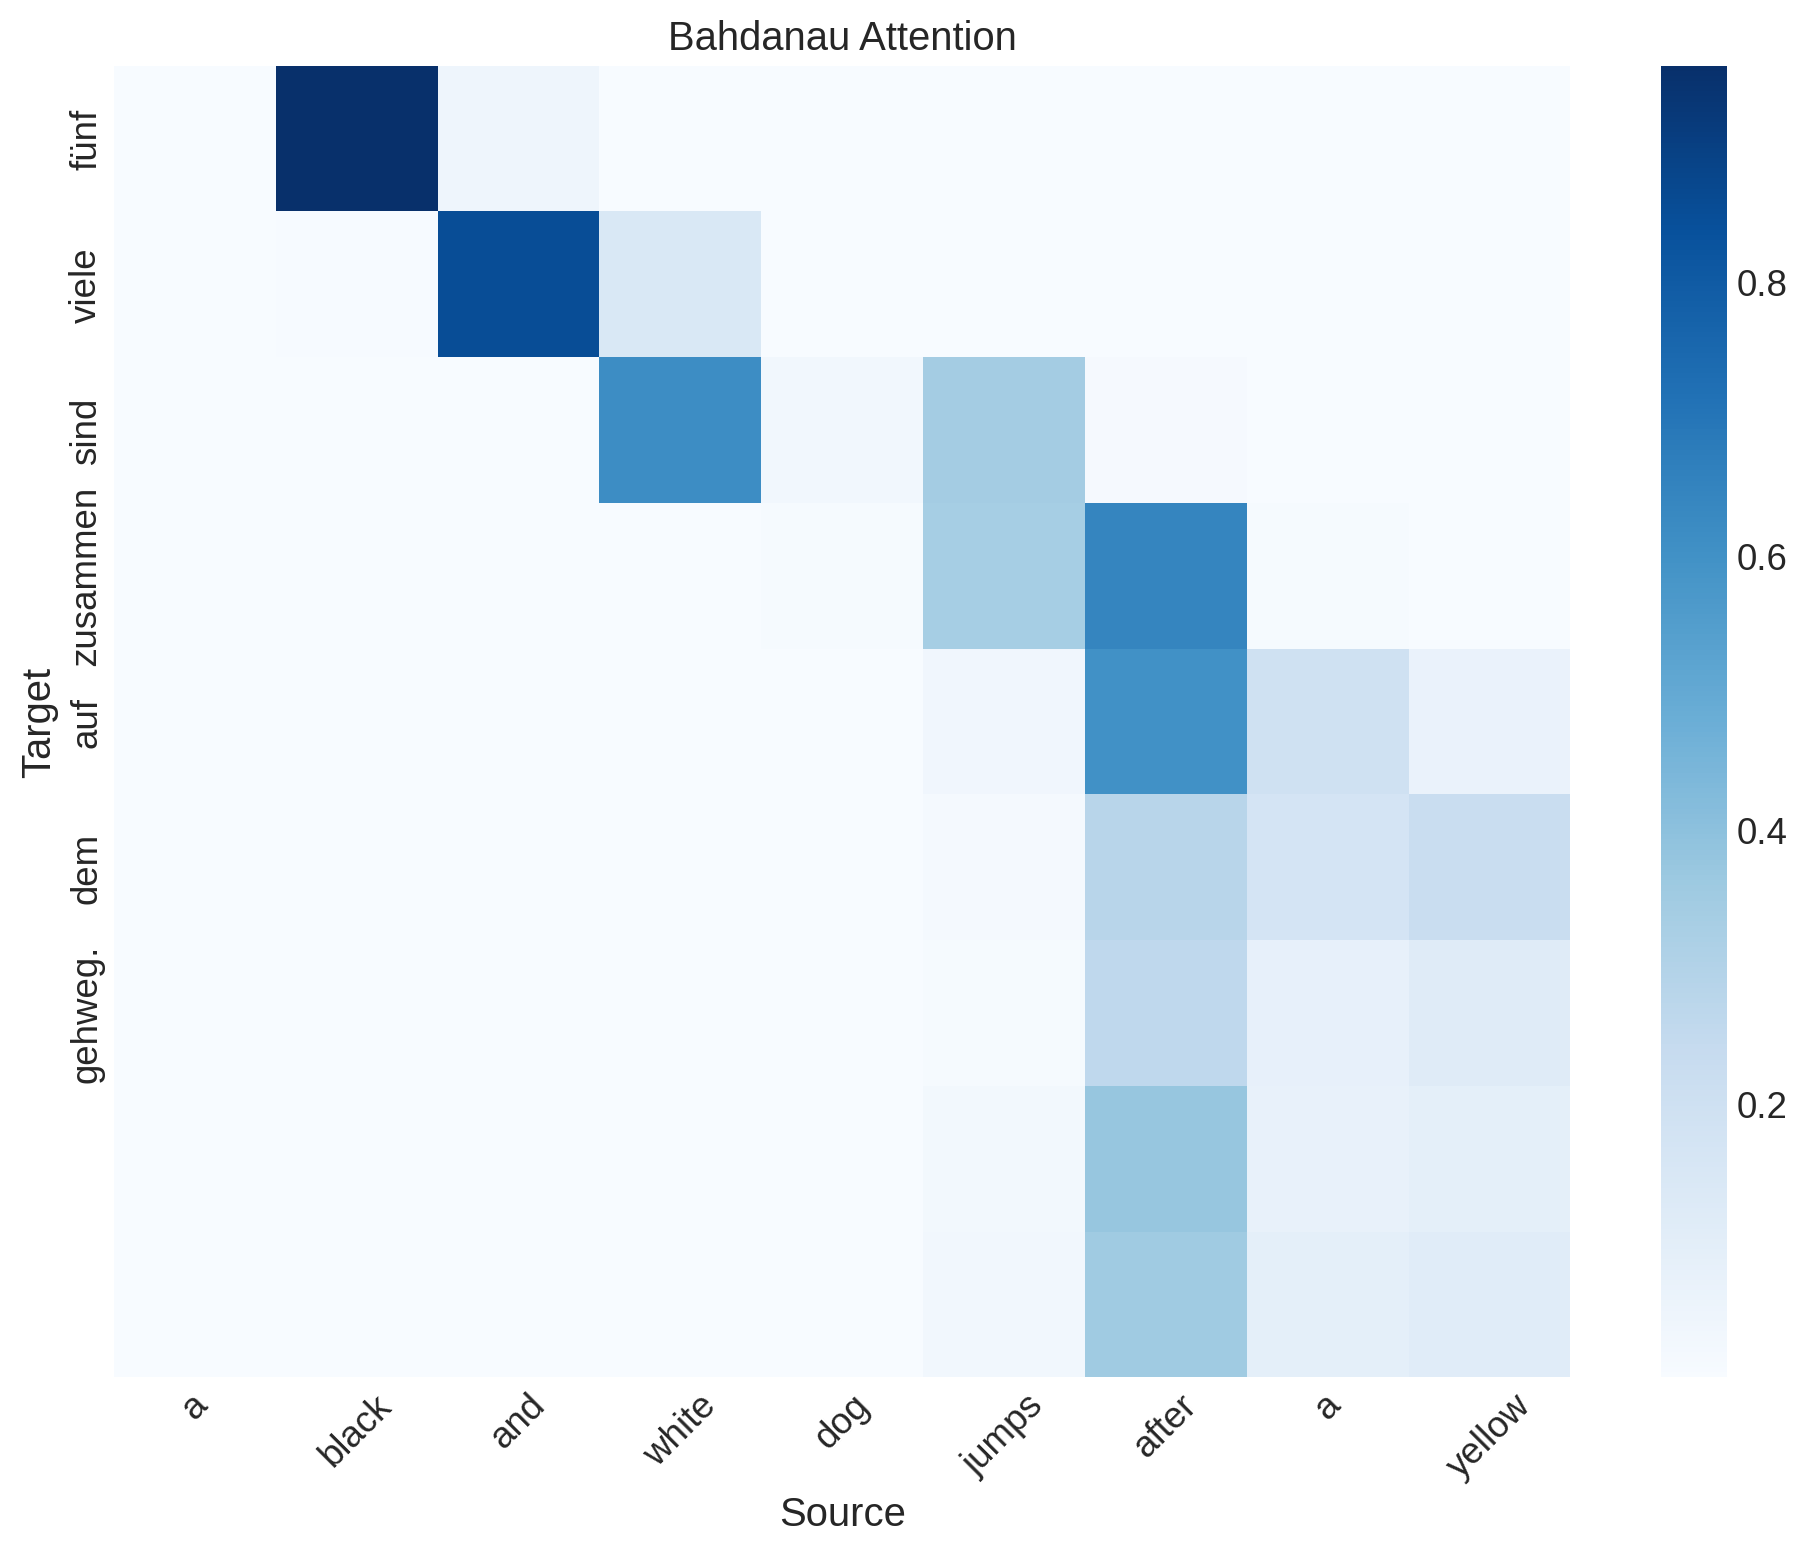

In [43]:
example_idx = 178

source = train_encoded[example_idx]["src"]
target = train_encoded[example_idx]["trg"]

predicted_text,attention_scores = beam_search_decode(
    model,
    source_tokens,
    beam_size=4,
    max_len=len(target),
    length_penalty=0.6,
    min_len=5
)
plot_attention_scores(source, predicted_text, attention_scores,9)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  